# PRE - PROCESSING

## Import functions

In [1]:
!pip install meteostat

In [2]:
pip install keras-tuner --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.9 MB/s eta 0:00:00


In [3]:
import holidays # For working with holiday data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import xgboost as xgb

from datetime import datetime
from meteostat import Stations, Daily # For working with weather data
from xgboost import plot_importance


from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

In [4]:
## Features Functions

def create_datetime_features(df):

    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date'] = pd.to_datetime(df.index.date)
    return df

def get_holiday_features(df, country_code='US'):
    """
    Creates holiday features from datetime index
    """
    year_range = list(range(min(df.index.year), max(df.index.year) + 1))
    country_holidays = holidays.country_holidays(
        country_code,
        years=year_range,
        observed=False
    )
    holiday_df = pd.DataFrame(country_holidays.items())
    holiday_df.columns = ['date', 'holiday']
    holiday_df['date'] = pd.to_datetime(holiday_df['date'])
    return holiday_df

def get_weather_features(df, lat, lon):
    """
    Creates weather features based on latitude and longitude
    """
    room_temperature = 20  # Weather data is in Celsius
    start = min(df.index)
    end = max(df.index)

    stations = Stations()
    stations = stations.nearby(lat, lon)
    station = stations.fetch(1)

    # Get daily data
    weather_data = Daily(station['wmo'][0], start, end)
    weather_data = weather_data.fetch()
    weather_data = weather_data.dropna(axis=1)
    weather_data = weather_data.reset_index()
    weather_data['tmin_abs_diff_from_room_temperature'] = abs(weather_data['tmin'] - room_temperature)
    weather_data['tmax_abs_diff_from_room_temperature'] = abs(weather_data['tmax'] - room_temperature)
    weather_data = weather_data.rename(columns ={'time': 'date'})

    return weather_data

## Import data and feature engineering

In [5]:
main = 'https://raw.githubusercontent.com/Brunchcode/Forecasting-Energy-Consumption-Using-Machine-Learning/main/data/Timeseries/Timeseries_PJM_DOM_consumption_2006_to_2024.csv'

data_main = pd.read_csv(main,index_col=[0], parse_dates=[0])
data = create_datetime_features(data_main)
holiday_features = get_holiday_features(data)
weather_features = get_weather_features(data, 37.5407, -77.4360) # Richmond Capital of Virgina
data['datetime'] = data.index
data = data.merge(holiday_features, how='left', on='date')
data['holiday'] = data['holiday'].fillna('')
data = pd.get_dummies(data)
data = data.merge(weather_features, how='left', on='date')


remove_for_case_study = datetime(2020, 1, 1)
data_till_2019 = data.loc[data['datetime'] <= remove_for_case_study].copy()
case_study_data = data.loc[data['datetime'] > remove_for_case_study].copy()

In [6]:
data.head()

energy_consumption_mw       date  hour  dayofweek  quarter  month  year  \
0                 9250.0 2006-01-01     0          6        1      1  2006   
1                 8978.0 2006-01-01     1          6        1      1  2006   
2                 8773.0 2006-01-01     2          6        1      1  2006   
3                 8671.0 2006-01-01     3          6        1      1  2006   
4                 8664.0 2006-01-01     4          6        1      1  2006   

   dayofyear  dayofmonth  weekofyear  ... holiday_Thanksgiving  \
0          1           1          52  ...                False   
1          1           1          52  ...                False   
2          1           1          52  ...                False   
3          1           1          52  ...                False   
4          1           1          52  ...                False   

   holiday_Veterans Day  holiday_Washington's Birthday  tavg  tmin  tmax  \
0                 False                          False   5.8  -1.1  11.7   
1                 False                          False   5.8  -1.1  11.7   
2                 False                          False   5.8  -1.1  11.7   
3                 False                          False   5.8  -1.1  11.7   
4                 False                          False   5.8  -1.1  11.7   

   prcp  wspd  tmin_abs_diff_from_room_temperature  \
0   0.0   4.0                                 21.1   
1   0.0   4.0                                 21.1   
2   0.0   4.0                                 21.1   
3   0.0   4.0                                 21.1   
4   0.0   4.0                                 21.1   

   tmax_abs_diff_from_room_temperature  
0                                  8.3  
1                                  8.3  
2                                  8.3  
3                                  8.3  
4                                  8.3  

[5 rows x 30 columns]

In [7]:
data.tail()

energy_consumption_mw       date  hour  dayofweek  quarter  month  \
162882              20498.376 2024-07-31    19          2        3      7   
162883              19814.648 2024-07-31    20          2        3      7   
162884              18910.259 2024-07-31    21          2        3      7   
162885              17645.255 2024-07-31    22          2        3      7   
162886              16421.592 2024-07-31    23          2        3      7   

        year  dayofyear  dayofmonth  weekofyear  ... holiday_Thanksgiving  \
162882  2024        213          31          31  ...                False   
162883  2024        213          31          31  ...                False   
162884  2024        213          31          31  ...                False   
162885  2024        213          31          31  ...                False   
162886  2024        213          31          31  ...                False   

        holiday_Veterans Day  holiday_Washington's Birthday  tavg  tmin  tmax  \
162882                 False                          False  26.2  22.2  32.2   
162883                 False                          False  26.2  22.2  32.2   
162884                 False                          False  26.2  22.2  32.2   
162885                 False                          False  26.2  22.2  32.2   
162886                 False                          False  26.2  22.2  32.2   

        prcp  wspd  tmin_abs_diff_from_room_temperature  \
162882   0.3   7.9                                  2.2   
162883   0.3   7.9                                  2.2   
162884   0.3   7.9                                  2.2   
162885   0.3   7.9                                  2.2   
162886   0.3   7.9                                  2.2   

        tmax_abs_diff_from_room_temperature  
162882                                 12.2  
162883                                 12.2  
162884                                 12.2  
162885                                 12.2  
162886                                 12.2  

[5 rows x 30 columns]

In [8]:
data_till_2019.head()

energy_consumption_mw       date  hour  dayofweek  quarter  month  year  \
0                 9250.0 2006-01-01     0          6        1      1  2006   
1                 8978.0 2006-01-01     1          6        1      1  2006   
2                 8773.0 2006-01-01     2          6        1      1  2006   
3                 8671.0 2006-01-01     3          6        1      1  2006   
4                 8664.0 2006-01-01     4          6        1      1  2006   

   dayofyear  dayofmonth  weekofyear  ... holiday_Thanksgiving  \
0          1           1          52  ...                False   
1          1           1          52  ...                False   
2          1           1          52  ...                False   
3          1           1          52  ...                False   
4          1           1          52  ...                False   

   holiday_Veterans Day  holiday_Washington's Birthday  tavg  tmin  tmax  \
0                 False                          False   5.8  -1.1  11.7   
1                 False                          False   5.8  -1.1  11.7   
2                 False                          False   5.8  -1.1  11.7   
3                 False                          False   5.8  -1.1  11.7   
4                 False                          False   5.8  -1.1  11.7   

   prcp  wspd  tmin_abs_diff_from_room_temperature  \
0   0.0   4.0                                 21.1   
1   0.0   4.0                                 21.1   
2   0.0   4.0                                 21.1   
3   0.0   4.0                                 21.1   
4   0.0   4.0                                 21.1   

   tmax_abs_diff_from_room_temperature  
0                                  8.3  
1                                  8.3  
2                                  8.3  
3                                  8.3  
4                                  8.3  

[5 rows x 30 columns]

In [9]:
data_till_2019.tail()

energy_consumption_mw       date  hour  dayofweek  quarter  month  \
122708              11442.870 2019-12-31    20          1        4     12   
122709              11166.770 2019-12-31    21          1        4     12   
122710              10838.550 2019-12-31    22          1        4     12   
122711              10592.674 2019-12-31    23          1        4     12   
122712              10364.707 2020-01-01     0          2        1      1   

        year  dayofyear  dayofmonth  weekofyear  ... holiday_Thanksgiving  \
122708  2019        365          31           1  ...                False   
122709  2019        365          31           1  ...                False   
122710  2019        365          31           1  ...                False   
122711  2019        365          31           1  ...                False   
122712  2020          1           1           1  ...                False   

        holiday_Veterans Day  holiday_Washington's Birthday  tavg  tmin  tmax  \
122708                 False                          False  10.9   5.0  13.9   
122709                 False                          False  10.9   5.0  13.9   
122710                 False                          False  10.9   5.0  13.9   
122711                 False                          False  10.9   5.0  13.9   
122712                 False                          False   7.1   1.7  12.2   

        prcp  wspd  tmin_abs_diff_from_room_temperature  \
122708   0.0  11.9                                 15.0   
122709   0.0  11.9                                 15.0   
122710   0.0  11.9                                 15.0   
122711   0.0  11.9                                 15.0   
122712   0.0  13.7                                 18.3   

        tmax_abs_diff_from_room_temperature  
122708                                  6.1  
122709                                  6.1  
122710                                  6.1  
122711                                  6.1  
122712                                  7.8  

[5 rows x 30 columns]

In [10]:
case_study_data.head()

energy_consumption_mw       date  hour  dayofweek  quarter  month  \
122713              10291.858 2020-01-01     1          2        1      1   
122714              10252.082 2020-01-01     2          2        1      1   
122715              10303.804 2020-01-01     3          2        1      1   
122716              10588.920 2020-01-01     4          2        1      1   
122717              10980.540 2020-01-01     5          2        1      1   

        year  dayofyear  dayofmonth  weekofyear  ... holiday_Thanksgiving  \
122713  2020          1           1           1  ...                False   
122714  2020          1           1           1  ...                False   
122715  2020          1           1           1  ...                False   
122716  2020          1           1           1  ...                False   
122717  2020          1           1           1  ...                False   

        holiday_Veterans Day  holiday_Washington's Birthday  tavg  tmin  tmax  \
122713                 False                          False   7.1   1.7  12.2   
122714                 False                          False   7.1   1.7  12.2   
122715                 False                          False   7.1   1.7  12.2   
122716                 False                          False   7.1   1.7  12.2   
122717                 False                          False   7.1   1.7  12.2   

        prcp  wspd  tmin_abs_diff_from_room_temperature  \
122713   0.0  13.7                                 18.3   
122714   0.0  13.7                                 18.3   
122715   0.0  13.7                                 18.3   
122716   0.0  13.7                                 18.3   
122717   0.0  13.7                                 18.3   

        tmax_abs_diff_from_room_temperature  
122713                                  7.8  
122714                                  7.8  
122715                                  7.8  
122716                                  7.8  
122717                                  7.8  

[5 rows x 30 columns]

In [11]:
case_study_data.tail()

energy_consumption_mw       date  hour  dayofweek  quarter  month  \
162882              20498.376 2024-07-31    19          2        3      7   
162883              19814.648 2024-07-31    20          2        3      7   
162884              18910.259 2024-07-31    21          2        3      7   
162885              17645.255 2024-07-31    22          2        3      7   
162886              16421.592 2024-07-31    23          2        3      7   

        year  dayofyear  dayofmonth  weekofyear  ... holiday_Thanksgiving  \
162882  2024        213          31          31  ...                False   
162883  2024        213          31          31  ...                False   
162884  2024        213          31          31  ...                False   
162885  2024        213          31          31  ...                False   
162886  2024        213          31          31  ...                False   

        holiday_Veterans Day  holiday_Washington's Birthday  tavg  tmin  tmax  \
162882                 False                          False  26.2  22.2  32.2   
162883                 False                          False  26.2  22.2  32.2   
162884                 False                          False  26.2  22.2  32.2   
162885                 False                          False  26.2  22.2  32.2   
162886                 False                          False  26.2  22.2  32.2   

        prcp  wspd  tmin_abs_diff_from_room_temperature  \
162882   0.3   7.9                                  2.2   
162883   0.3   7.9                                  2.2   
162884   0.3   7.9                                  2.2   
162885   0.3   7.9                                  2.2   
162886   0.3   7.9                                  2.2   

        tmax_abs_diff_from_room_temperature  
162882                                 12.2  
162883                                 12.2  
162884                                 12.2  
162885                                 12.2  
162886                                 12.2  

[5 rows x 30 columns]

# DEEP LEARNING LSTM

## Model 1

Epoch 1/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - loss: 0.0767 - val_loss: 0.0165
Epoch 2/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 0.0142 - val_loss: 0.0104
Epoch 3/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 0.0101 - val_loss: 0.0100
Epoch 4/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0096 - val_loss: 0.0092
Epoch 5/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - loss: 0.0091 - val_loss: 0.0083
Epoch 6/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.0084 - val_loss: 0.0075
Epoch 7/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - loss: 0.0077 - val_loss: 0.0073
Epoch 8/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - loss: 0.0070 - val_loss: 0.0064
Epoch 9/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 11s 89ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 10/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 74ms/step - loss: 0.0062 - val_loss: 0.0059
Epoch 11/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 0.0060 - val_loss: 0.0054
Epoch 12/100
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 

2740/2740 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
RMSE: 673.9401807869086
MAE: 528.4659374922016
MAPE: 0.0464132236519554


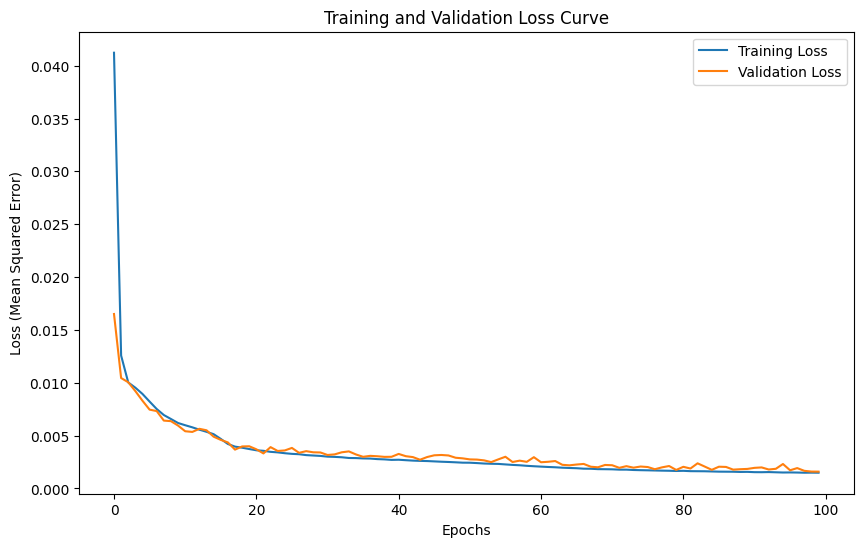

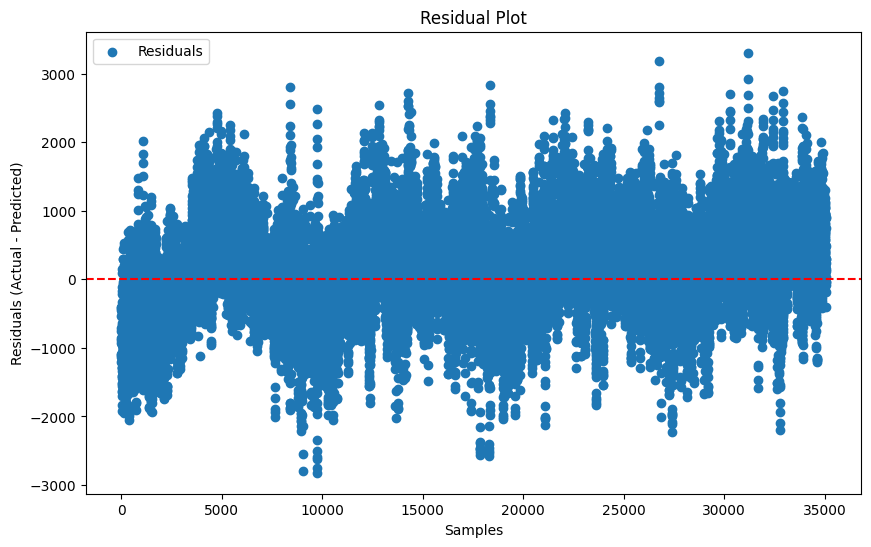

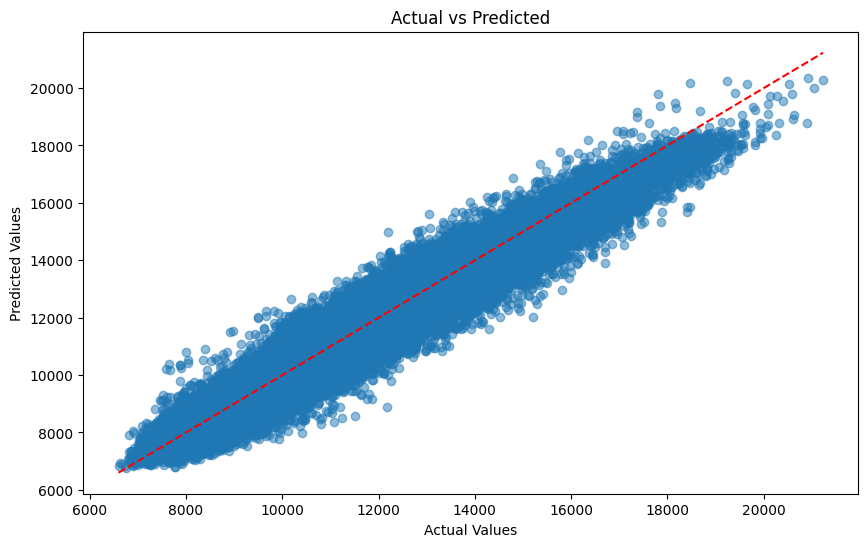

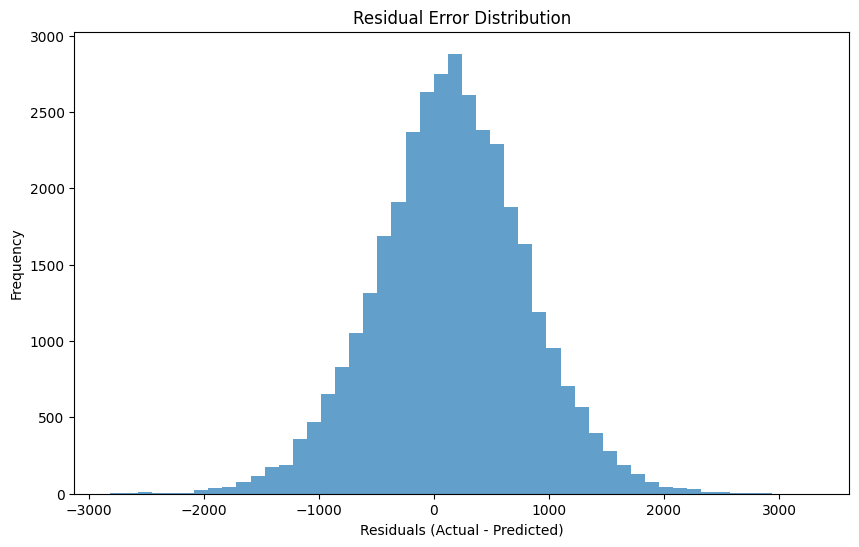

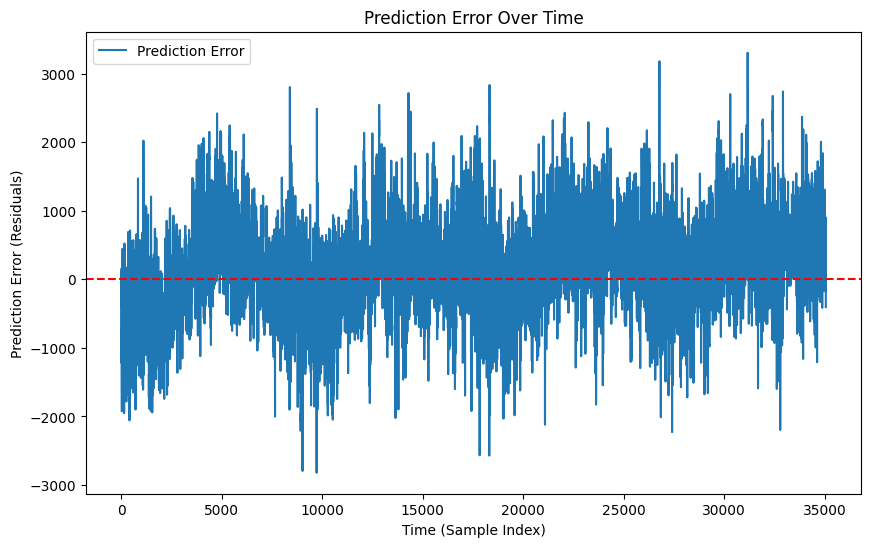

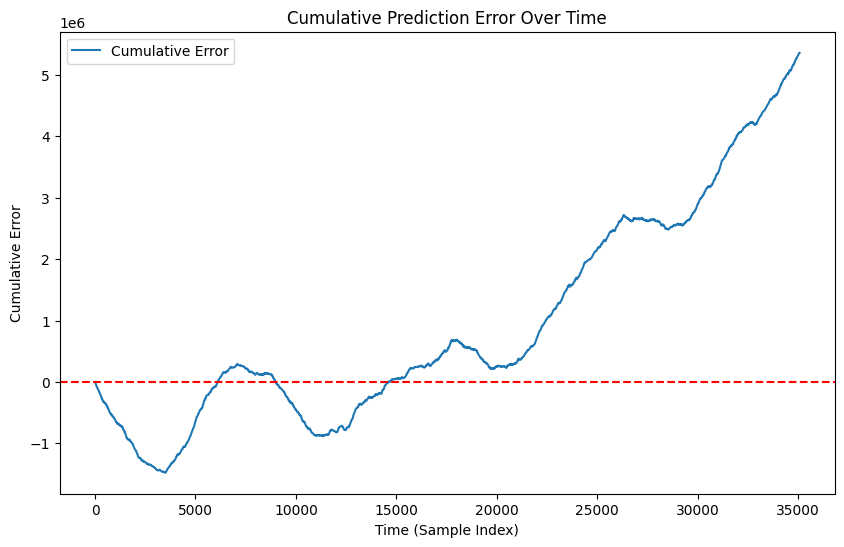

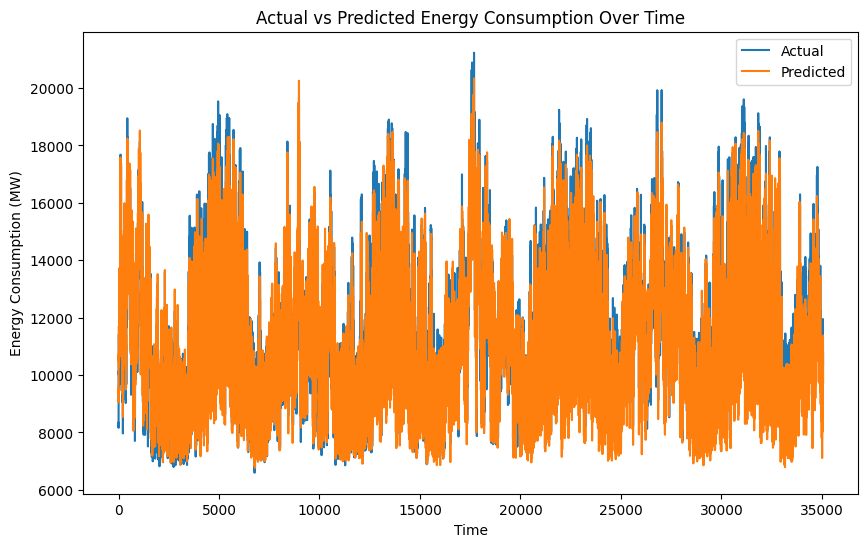

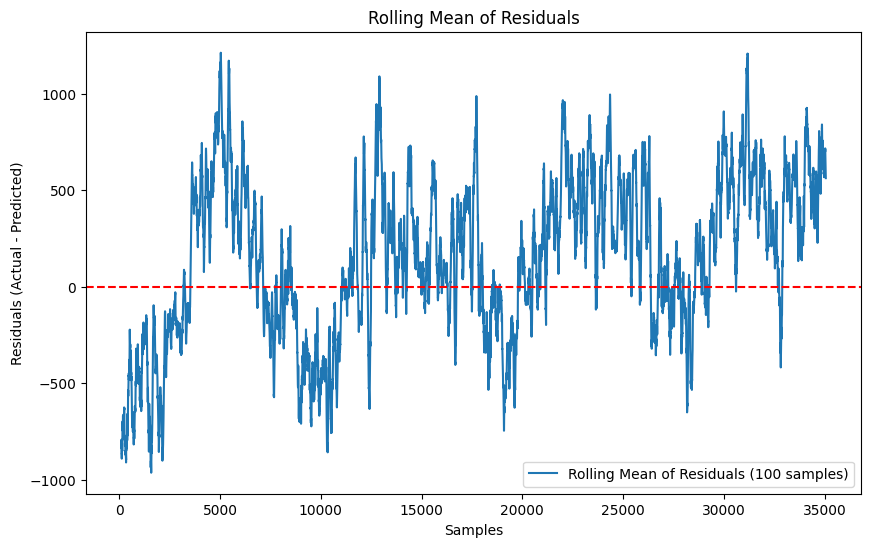

<Figure size 1000x600 with 0 Axes>

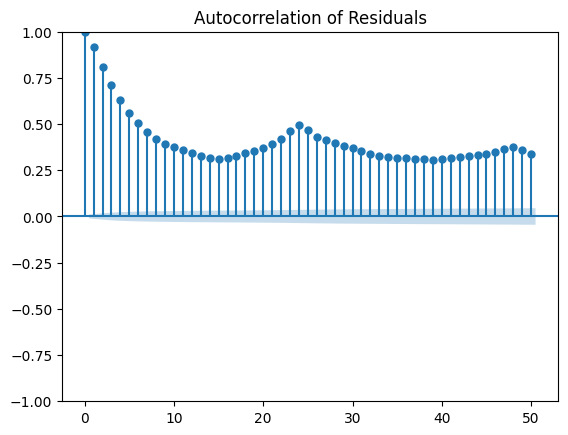

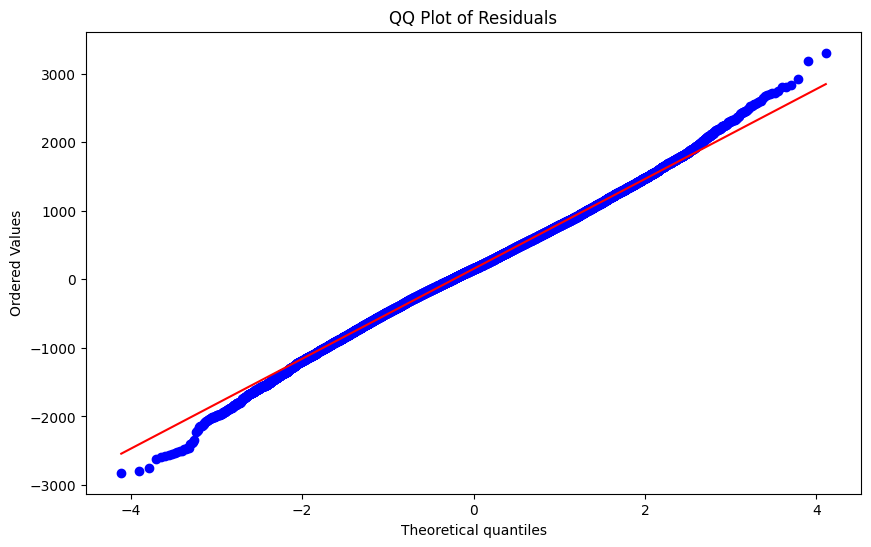

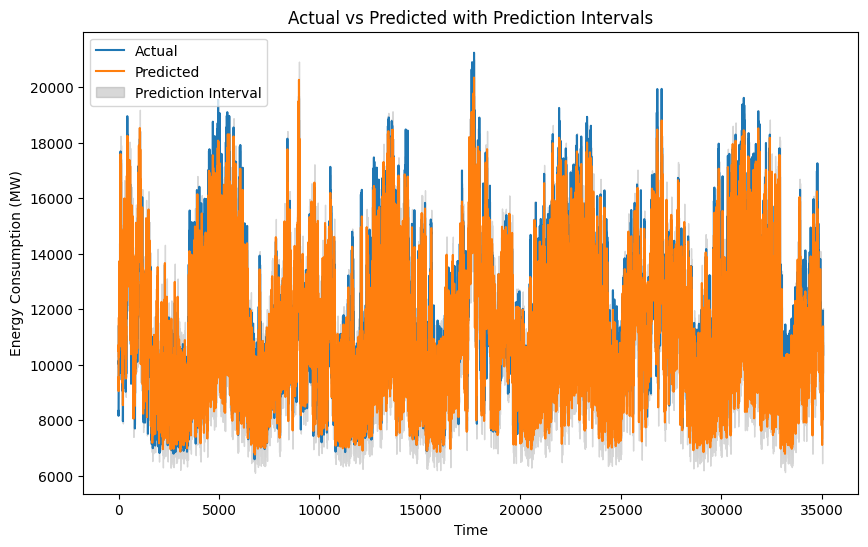

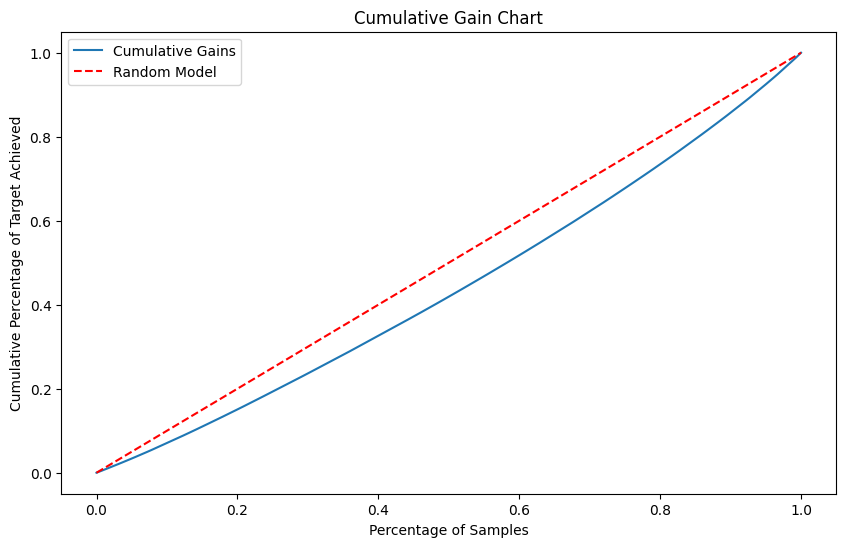

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
RMSE: 673.9401807869086
MAE: 528.4659374922016
MAPE: 0.0464132236519554


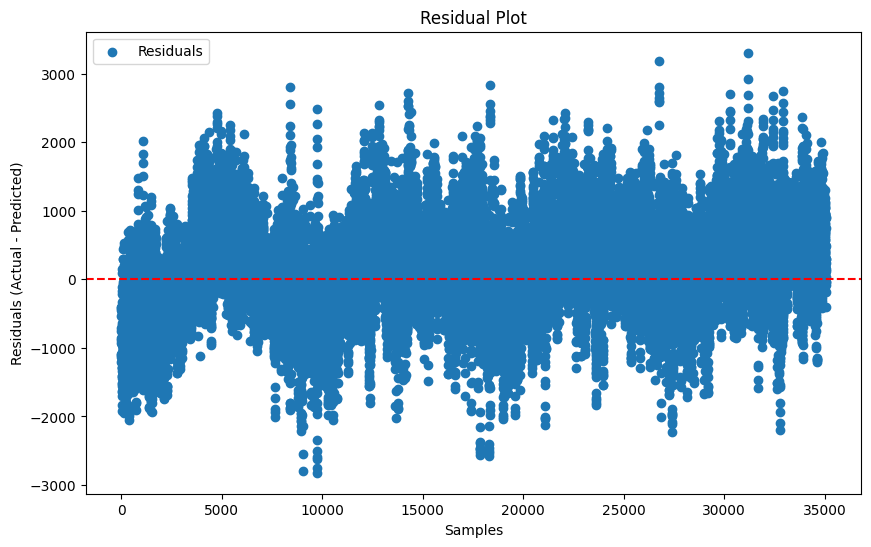

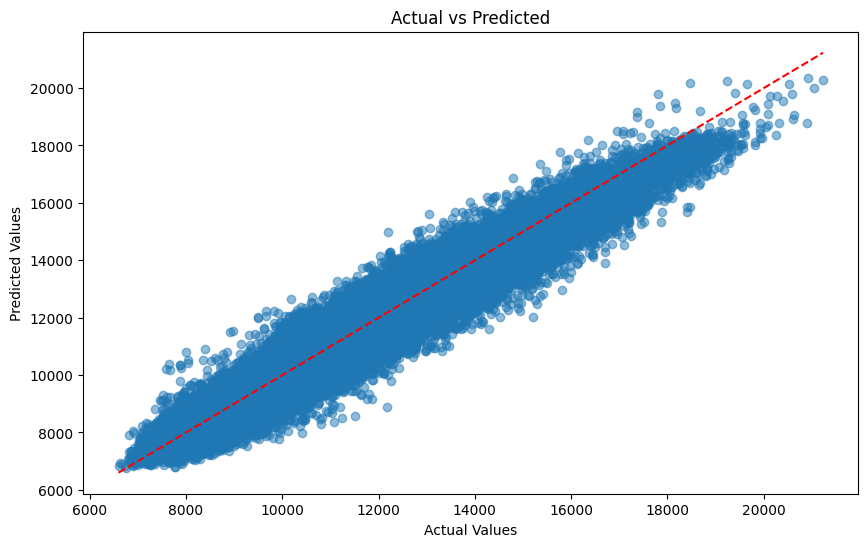

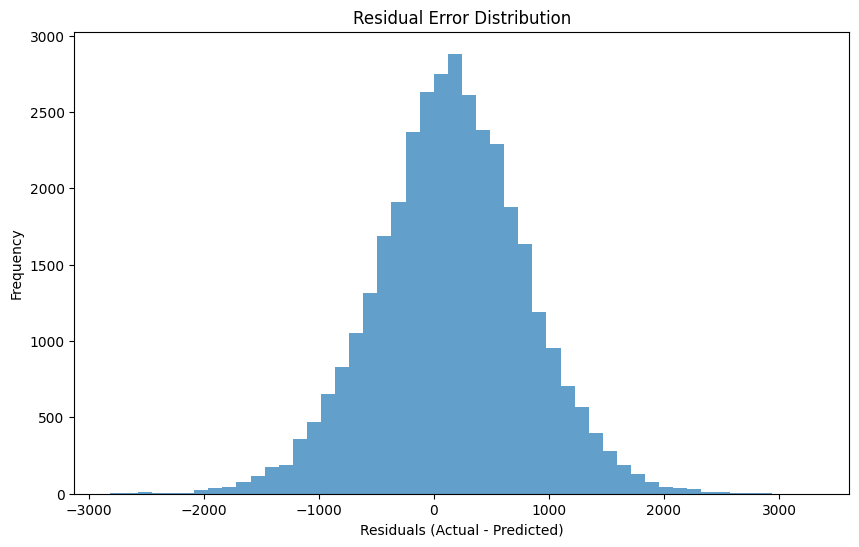

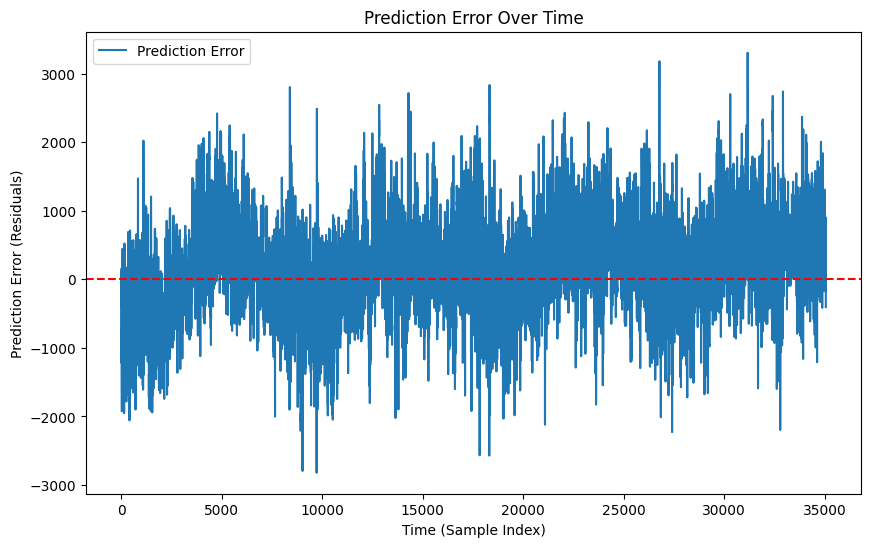

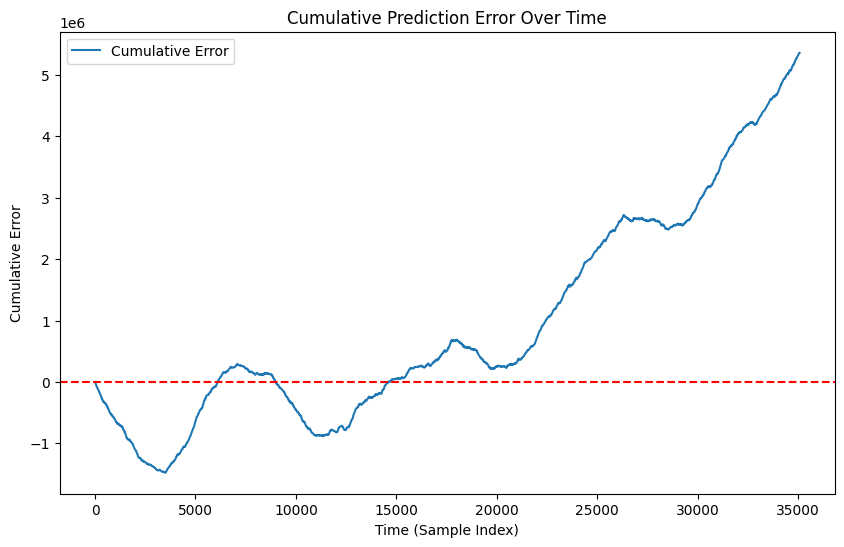

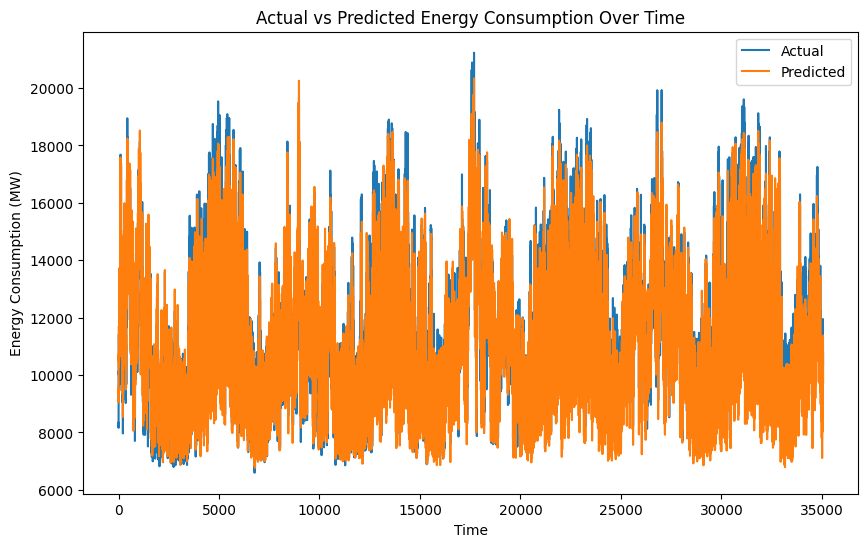

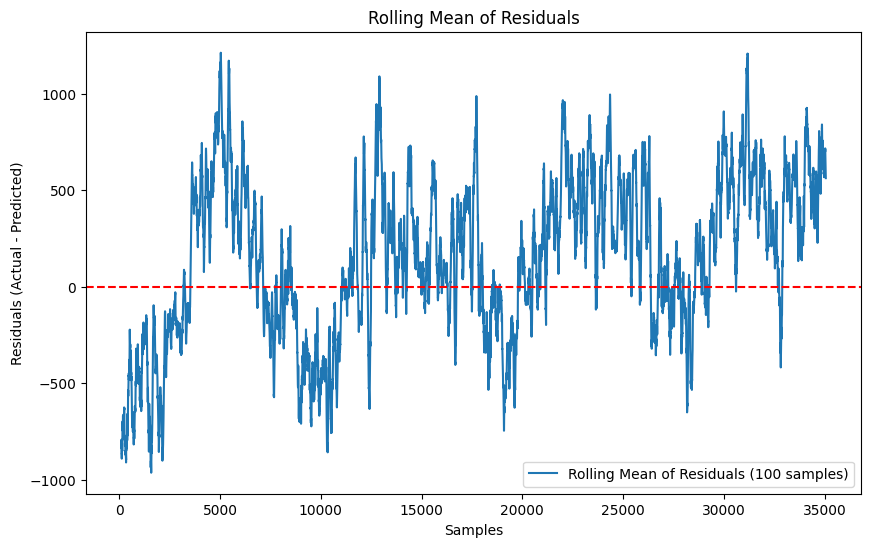

<Figure size 1000x600 with 0 Axes>

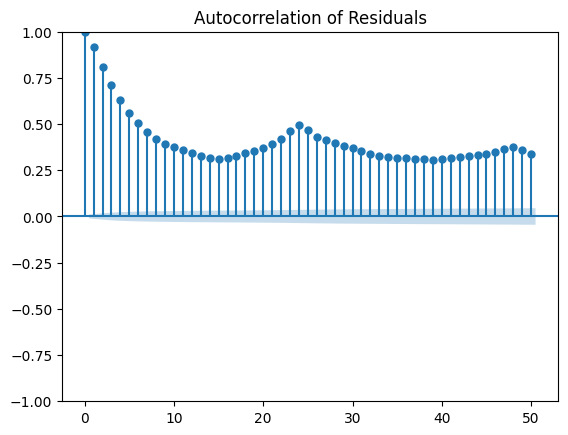

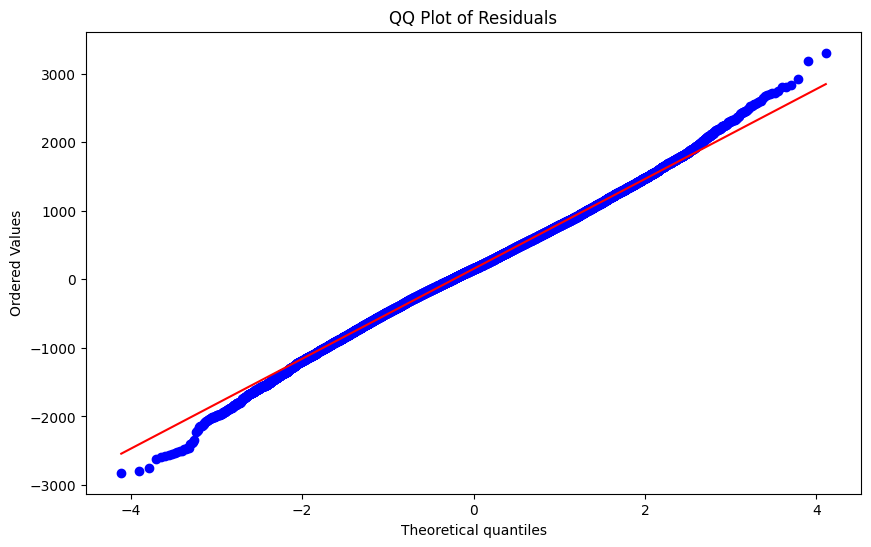

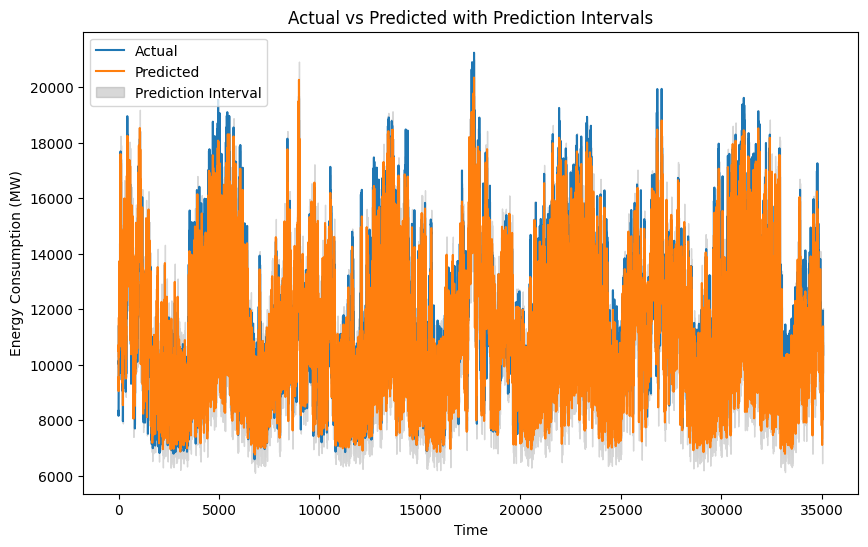

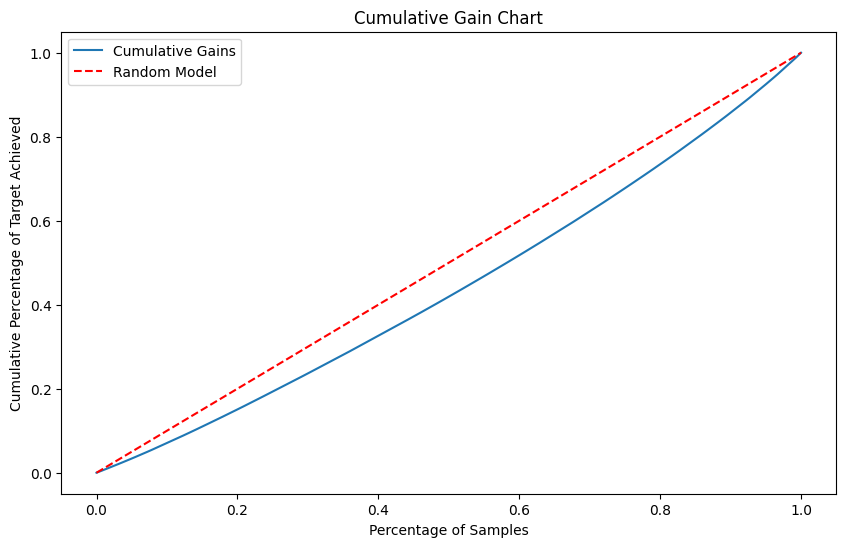

In [15]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots  # For Autocorrelation plot
import scipy.stats as stats
from datetime import datetime

# Assuming 'data_till_2019' is your dataframe and 'energy_consumption_mw' is the target variable.

# Define your split date for train and test data
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

# Dropping unnecessary columns for features
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Scale the data using MinMaxScaler (LSTMs perform better with normalized data)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input to be [samples, time steps, features] for LSTM
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the LSTM model
def build_lstm_model(X_train):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for regression task

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build and fit the model
model = build_lstm_model(X_train_scaled)
history = model.fit(X_train_scaled, y_train_scaled,
                    validation_data=(X_test_scaled, y_test_scaled),
                    epochs=100,
                    batch_size=1000,
                    verbose=1)

# Save the model after training
model.save('lstm_energy_model1.h5')

# Evaluate the model before saving
def evaluate_and_plot_model(y_true, y_pred, history=None):
    y_true_inv = scaler_y.inverse_transform(y_true)
    y_pred_inv = scaler_y.inverse_transform(y_pred)

    rmse = mean_squared_error(y_true_inv, y_pred_inv, squared=False)
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv)

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")

    # 6.1 Loss Curve
    if history is not None:
        # Loss Curve with both training and validation loss
        plt.figure(figsize=(10,6))
        plt.plot(history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Mean Squared Error)')
        plt.legend()
        plt.show()

    # 6.2 Residual Plot
    residuals = y_true_inv - y_pred_inv
    plt.figure(figsize=(10,6))
    plt.scatter(range(len(residuals)), residuals, label='Residuals')
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Samples')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.legend()
    plt.show()

    # 6.3 Actual vs Predicted Scatter Plot
    plt.figure(figsize=(10,6))
    plt.scatter(y_true_inv, y_pred_inv, alpha=0.5)
    plt.plot([y_true_inv.min(), y_true_inv.max()], [y_true_inv.min(), y_true_inv.max()], 'r--')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    # 6.4 Error Distribution (Histogram)
    plt.figure(figsize=(10,6))
    plt.hist(residuals, bins=50, alpha=0.7)
    plt.title('Residual Error Distribution')
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.show()

    # 6.5 Prediction Error Over Time
    plt.figure(figsize=(10,6))
    plt.plot(residuals, label='Prediction Error')
    plt.title('Prediction Error Over Time')
    plt.xlabel('Time (Sample Index)')
    plt.ylabel('Prediction Error (Residuals)')
    plt.axhline(0, color='r', linestyle='--')
    plt.legend()
    plt.show()

    # 6.6 Cumulative Prediction Error
    cumulative_error = np.cumsum(residuals)
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_error, label='Cumulative Error')
    plt.title('Cumulative Prediction Error Over Time')
    plt.xlabel('Time (Sample Index)')
    plt.ylabel('Cumulative Error')
    plt.axhline(0, color='r', linestyle='--')
    plt.legend()
    plt.show()

    # 6.7 Actual vs Predicted Over Time
    plt.figure(figsize=(10,6))
    plt.plot(y_true_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.title('Actual vs Predicted Energy Consumption Over Time')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()

    # 7.1 Rolling Mean of Residuals
    rolling_window = 100  # Adjust this window size
    rolling_mean_residual = pd.Series(residuals.flatten()).rolling(window=rolling_window).mean()
    plt.figure(figsize=(10,6))
    plt.plot(rolling_mean_residual, label=f'Rolling Mean of Residuals ({rolling_window} samples)')
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Rolling Mean of Residuals')
    plt.xlabel('Samples')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.legend()
    plt.show()

    # 7.2 Autocorrelation of Residuals
    plt.figure(figsize=(10,6))
    sm.graphics.tsa.plot_acf(residuals.flatten(), lags=50)
    plt.title('Autocorrelation of Residuals')
    plt.show()

    # 7.3 QQ Plot of Residuals
    plt.figure(figsize=(10,6))
    stats.probplot(residuals.flatten(), dist="norm", plot=plt)
    plt.title('QQ Plot of Residuals')
    plt.show()

    # 7.4 Prediction Interval
    residual_std = np.std(residuals)
    upper_bound = y_pred_inv + residual_std
    lower_bound = y_pred_inv - residual_std
    plt.figure(figsize=(10,6))
    plt.plot(y_true_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.fill_between(range(len(y_true_inv)), lower_bound.flatten(), upper_bound.flatten(), color='gray', alpha=0.3, label='Prediction Interval')
    plt.title('Actual vs Predicted with Prediction Intervals')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()

    # 7.5 Cumulative Gain Chart
    def plot_cumulative_gain(y_true, y_pred):
        sorted_indices = np.argsort(y_pred.flatten())
        sorted_true = np.array(y_true).flatten()[sorted_indices]
        gains = np.cumsum(sorted_true) / np.sum(sorted_true)
        plt.figure(figsize=(10,6))
        plt.plot(np.arange(len(gains)) / len(gains), gains, label='Cumulative Gains')
        plt.plot([0, 1], [0, 1], '--', color='red', label='Random Model')
        plt.title('Cumulative Gain Chart')
        plt.xlabel('Percentage of Samples')
        plt.ylabel('Cumulative Percentage of Target Achieved')
        plt.legend()
        plt.show()

    plot_cumulative_gain(y_true_inv, y_pred_inv)

# Evaluate the original model
train_predictions = model.predict(X_train_scaled)
test_predictions = model.predict(X_test_scaled)
evaluate_and_plot_model(y_test_scaled, test_predictions, history)

# Load the model and re-evaluate
loaded_model = load_model('lstm_energy_model1.h5')

# Make predictions using the loaded model
test_predictions_loaded = loaded_model.predict(X_test_scaled)

# Re-evaluate the loaded model
evaluate_and_plot_model(y_test_scaled, test_predictions_loaded)


## model 2

Epoch 1/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 84ms/step - loss: 0.0746 - val_loss: 0.0159
Epoch 2/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 88ms/step - loss: 0.0134 - val_loss: 0.0100
Epoch 3/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0102 - val_loss: 0.0093
Epoch 4/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - loss: 0.0096 - val_loss: 0.0093
Epoch 5/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 0.0091 - val_loss: 0.0084
Epoch 6/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0084 - val_loss: 0.0083
Epoch 7/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0077 - val_loss: 0.0067
Epoch 8/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 9/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - loss: 0.0064 - val_loss: 0.0058
Epoch 10/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.0061 - val_loss: 0.0056
Epoch 11/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - loss: 0.0058 - val_loss: 0.0055
Epoch 12/150
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/st

2740/2740 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
RMSE: 717.0632353225442
MAE: 565.1929325689498
MAPE: 0.04897829299971247


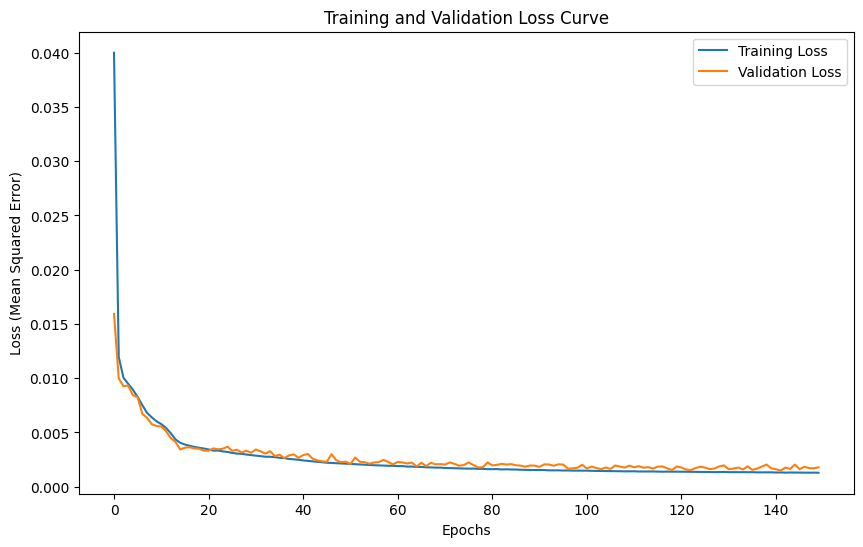

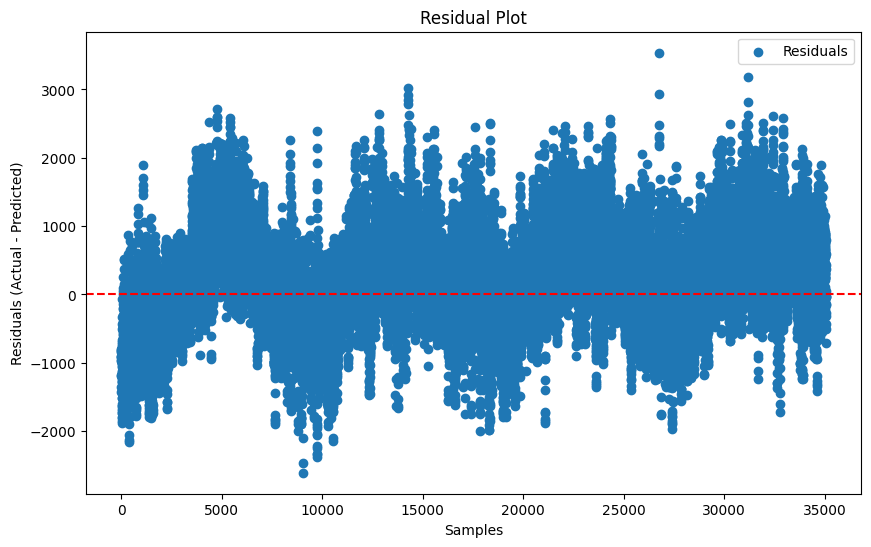

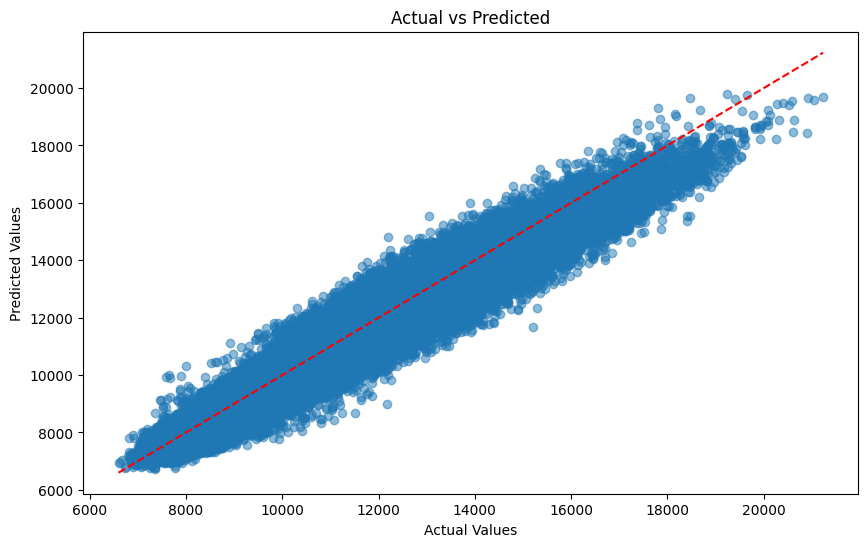

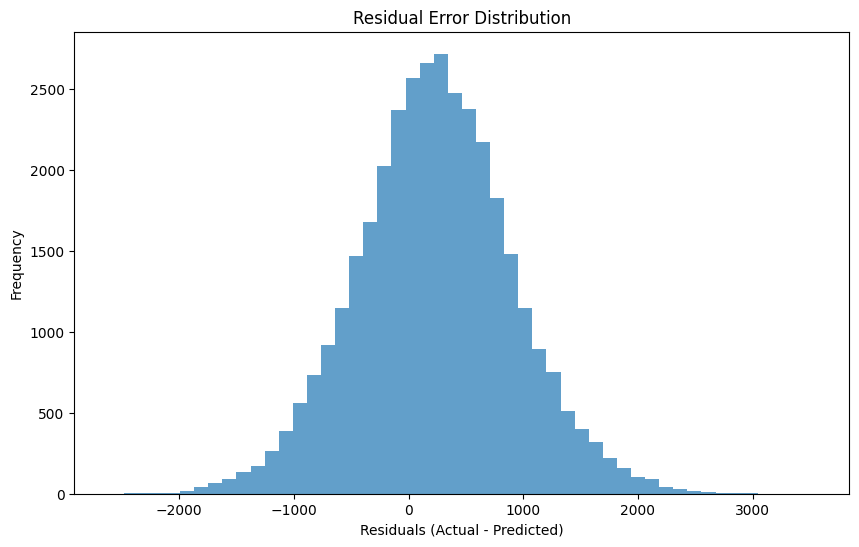

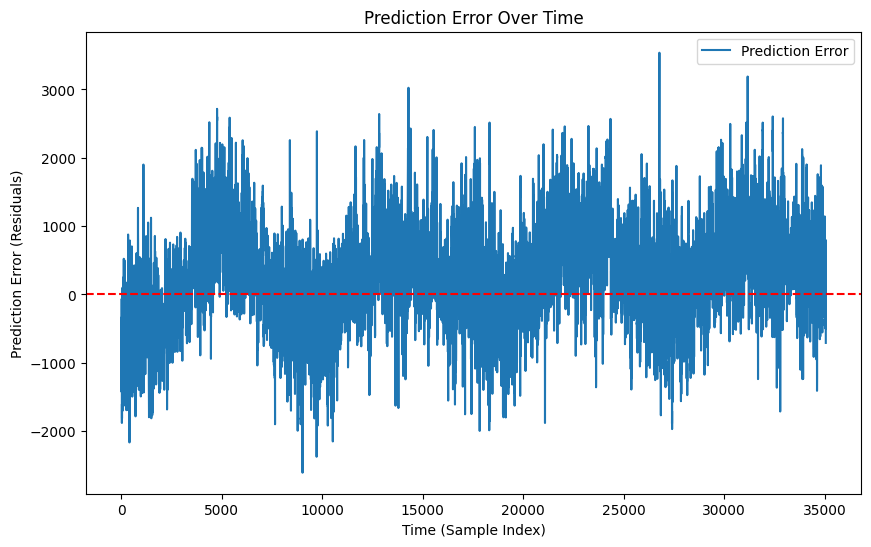

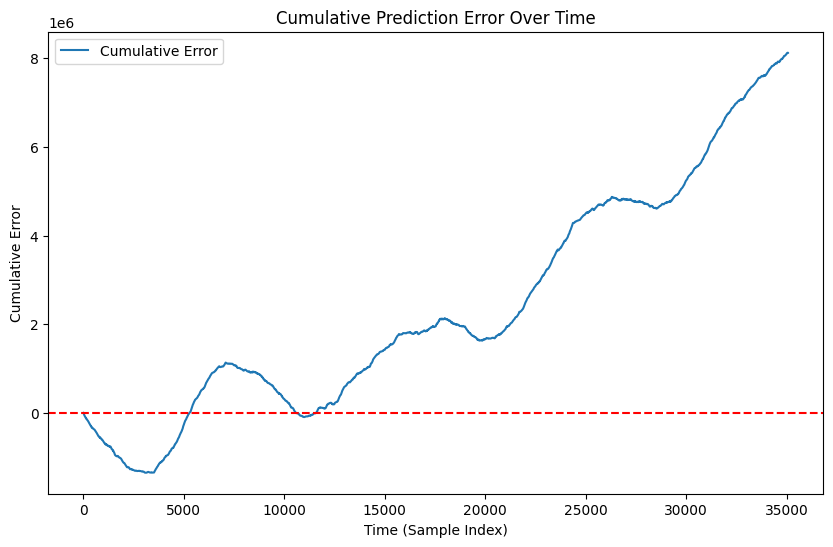

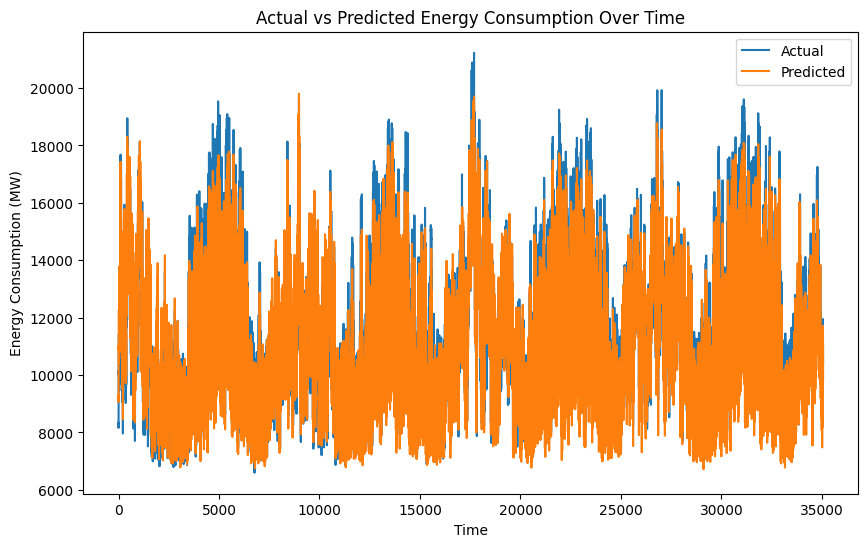

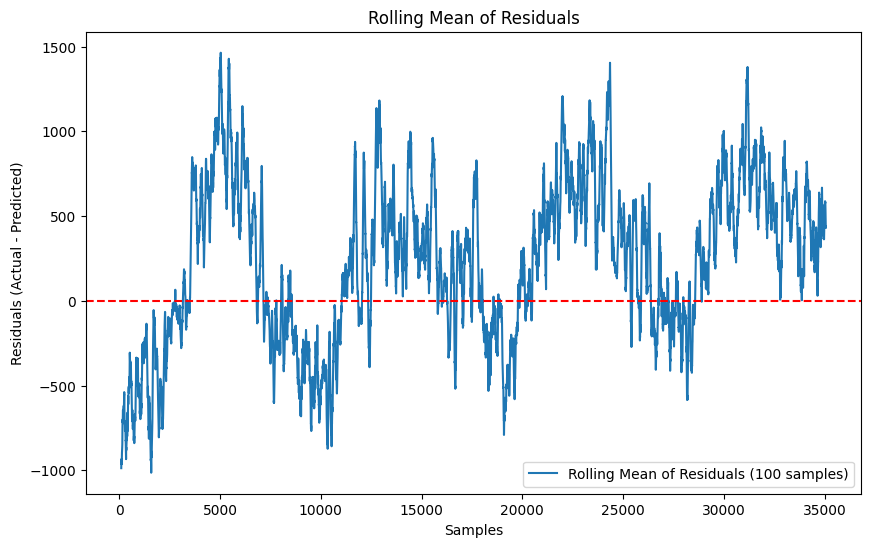

<Figure size 1000x600 with 0 Axes>

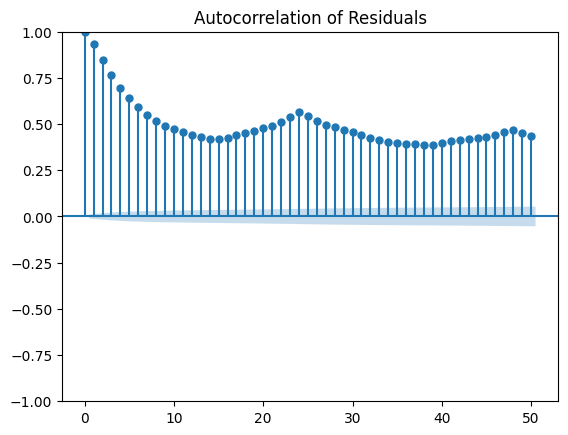

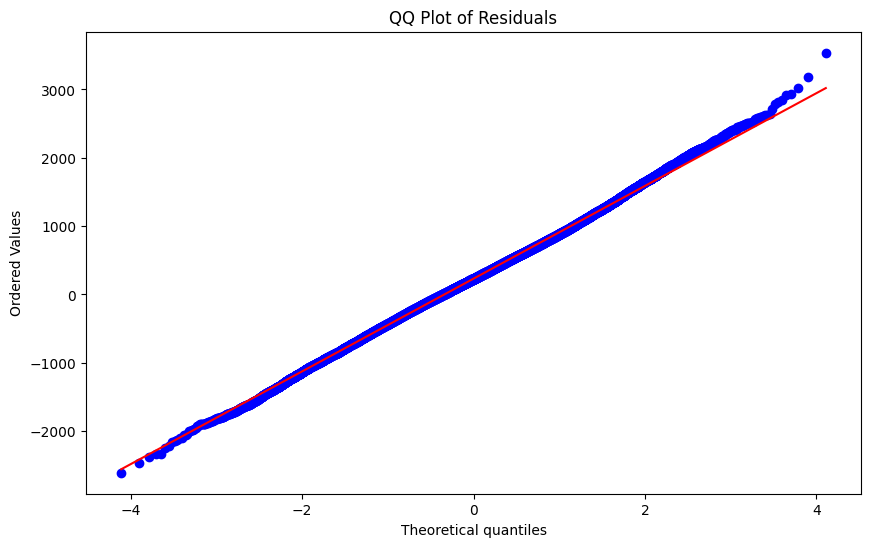

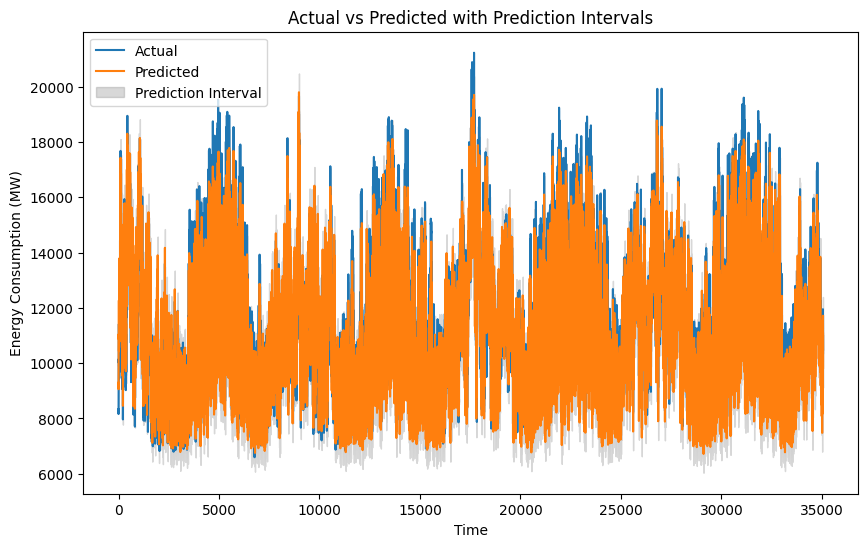

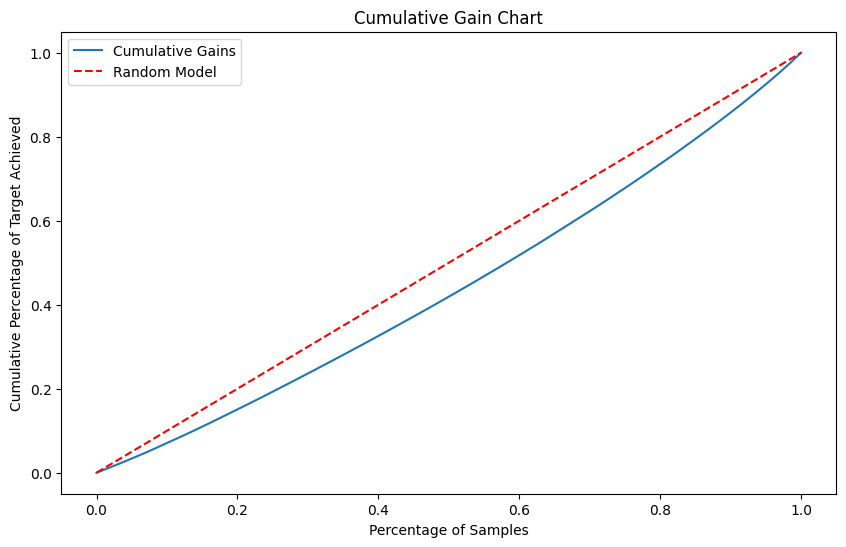

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step
RMSE: 717.0632353225442
MAE: 565.1929325689498
MAPE: 0.04897829299971247


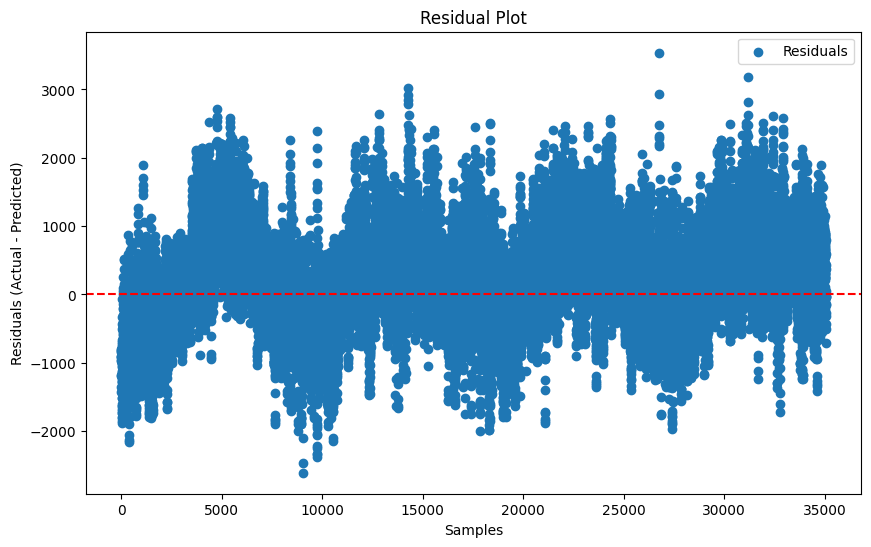

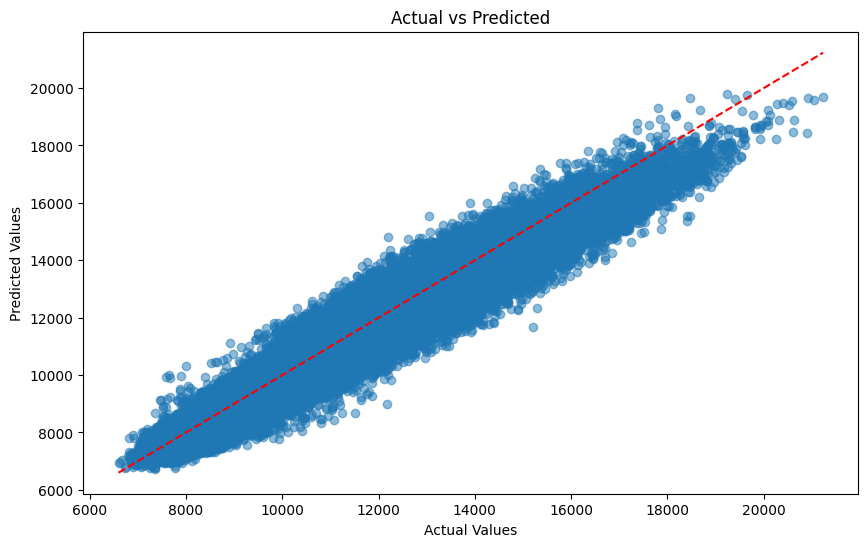

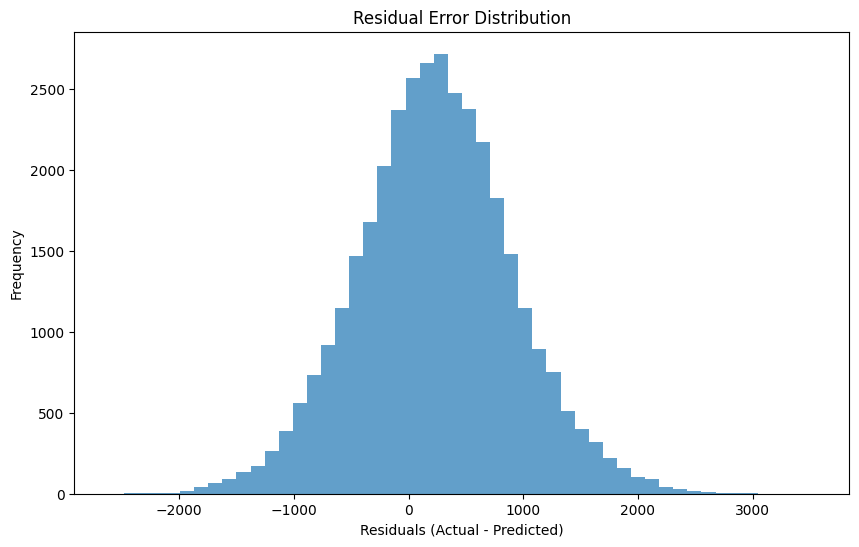

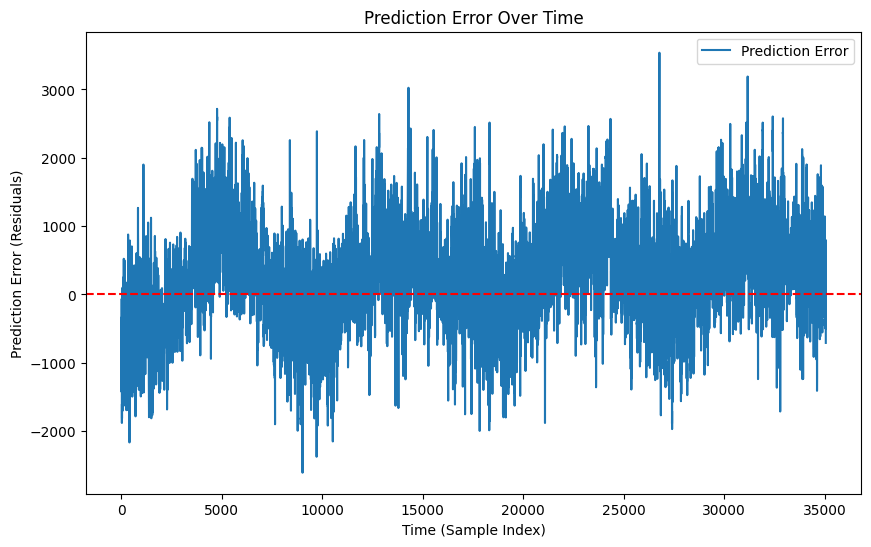

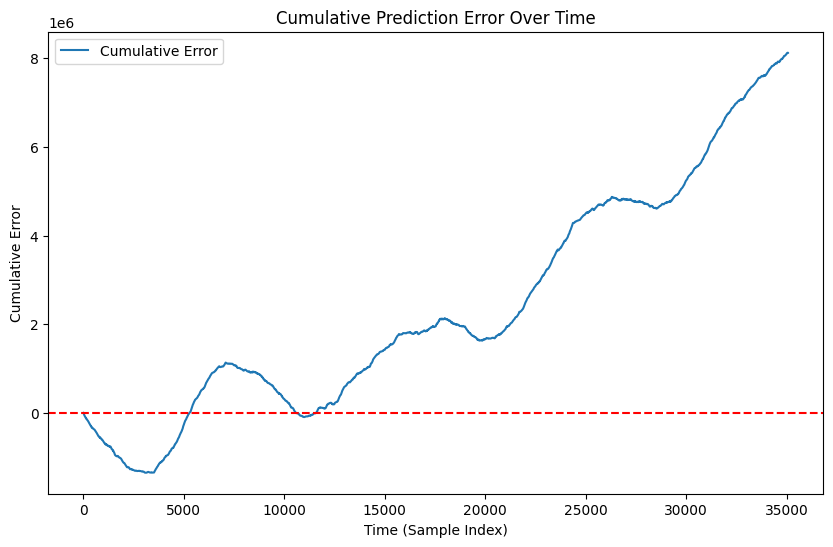

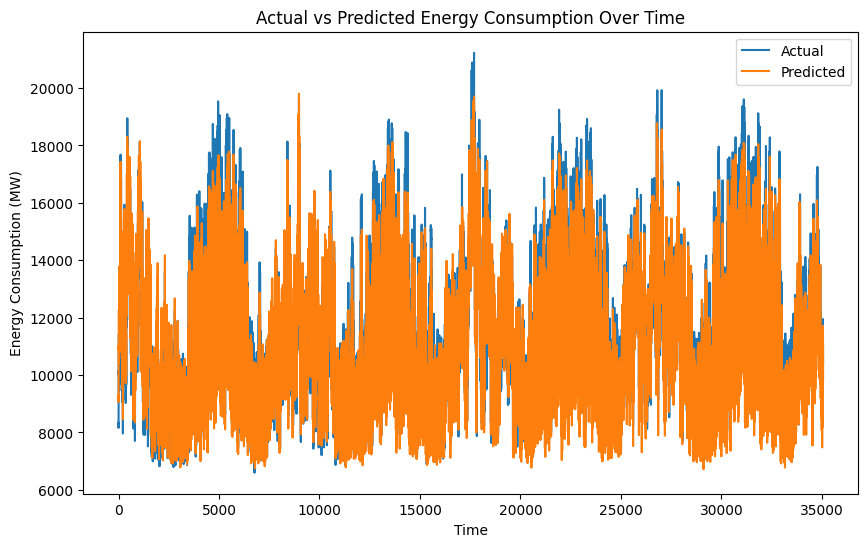

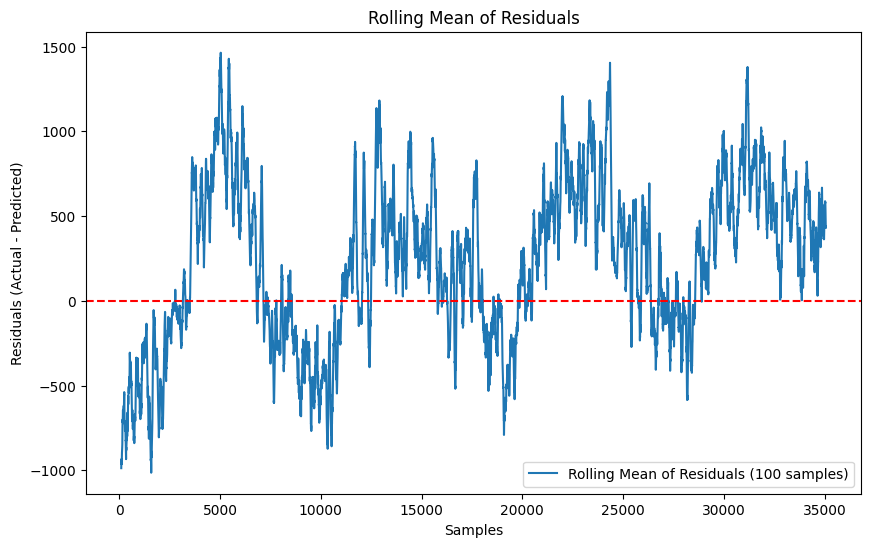

<Figure size 1000x600 with 0 Axes>

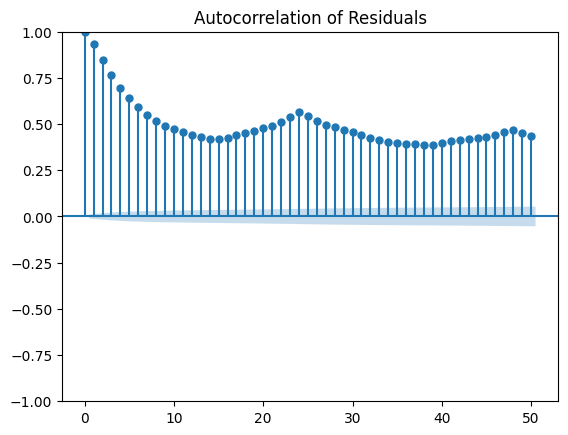

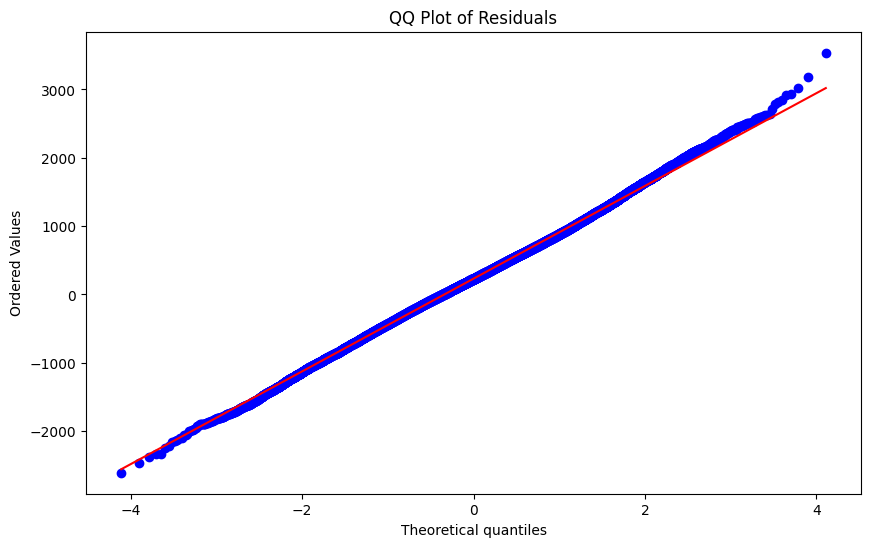

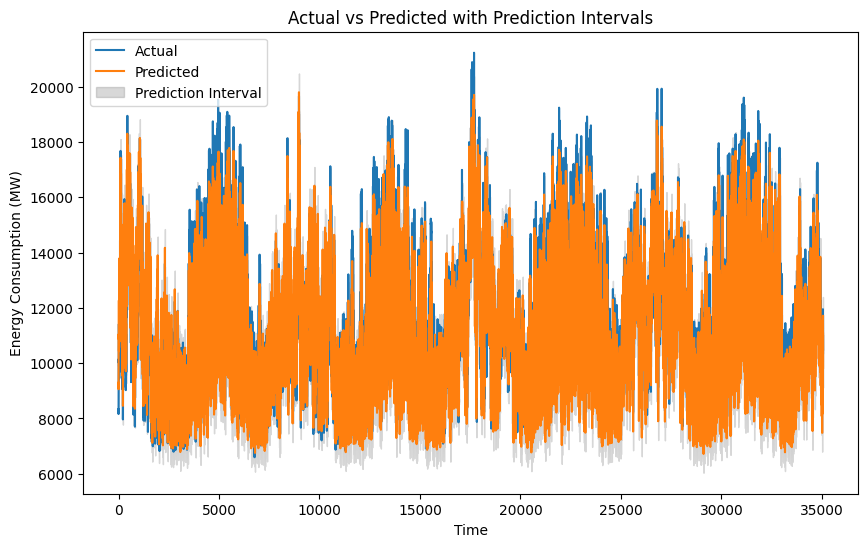

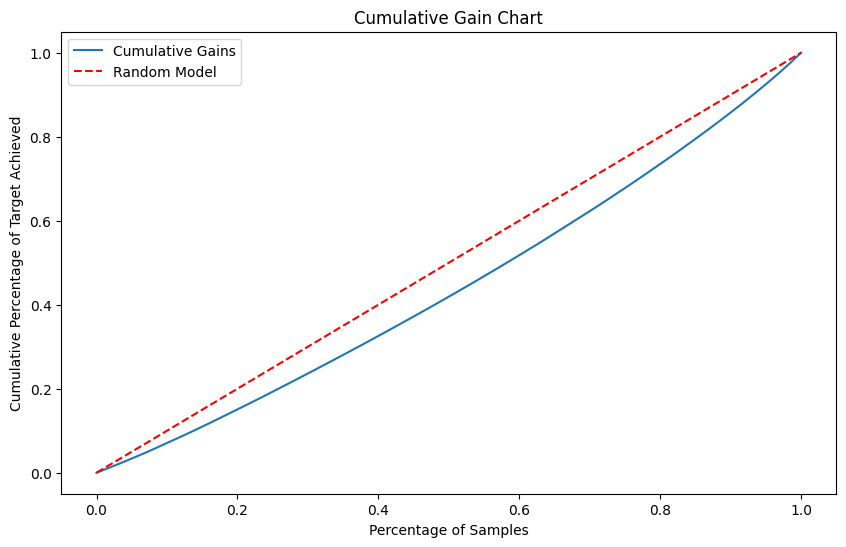

In [16]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots  # For Autocorrelation plot
import scipy.stats as stats
from datetime import datetime

# Assuming 'data_till_2019' is your dataframe and 'energy_consumption_mw' is the target variable.

# Define your split date for train and test data
split_date = datetime(2016, 1, 1)
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

# Dropping unnecessary columns for features
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Scale the data using MinMaxScaler (LSTMs perform better with normalized data)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input to be [samples, time steps, features] for LSTM
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Define the LSTM model
def build_lstm_model(X_train):
    model = Sequential()
    model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=100, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Output layer for regression task

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Build and fit the model
model = build_lstm_model(X_train_scaled)
history = model.fit(X_train_scaled, y_train_scaled,
                    validation_data=(X_test_scaled, y_test_scaled),
                    epochs=150,
                    batch_size=1000,
                    verbose=1)

# Save the model after training
model.save('lstm_energy_model2.h5')

# Evaluate the model before saving
def evaluate_and_plot_model(y_true, y_pred, history=None):
    y_true_inv = scaler_y.inverse_transform(y_true)
    y_pred_inv = scaler_y.inverse_transform(y_pred)

    rmse = mean_squared_error(y_true_inv, y_pred_inv, squared=False)
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv)

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")

    # 6.1 Loss Curve
    if history is not None:
        # Loss Curve with both training and validation loss
        plt.figure(figsize=(10,6))
        plt.plot(history.history['loss'], label='Training Loss')
        if 'val_loss' in history.history:
            plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Mean Squared Error)')
        plt.legend()
        plt.show()

    # 6.2 Residual Plot
    residuals = y_true_inv - y_pred_inv
    plt.figure(figsize=(10,6))
    plt.scatter(range(len(residuals)), residuals, label='Residuals')
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Samples')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.legend()
    plt.show()

    # 6.3 Actual vs Predicted Scatter Plot
    plt.figure(figsize=(10,6))
    plt.scatter(y_true_inv, y_pred_inv, alpha=0.5)
    plt.plot([y_true_inv.min(), y_true_inv.max()], [y_true_inv.min(), y_true_inv.max()], 'r--')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    # 6.4 Error Distribution (Histogram)
    plt.figure(figsize=(10,6))
    plt.hist(residuals, bins=50, alpha=0.7)
    plt.title('Residual Error Distribution')
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.show()

    # 6.5 Prediction Error Over Time
    plt.figure(figsize=(10,6))
    plt.plot(residuals, label='Prediction Error')
    plt.title('Prediction Error Over Time')
    plt.xlabel('Time (Sample Index)')
    plt.ylabel('Prediction Error (Residuals)')
    plt.axhline(0, color='r', linestyle='--')
    plt.legend()
    plt.show()

    # 6.6 Cumulative Prediction Error
    cumulative_error = np.cumsum(residuals)
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_error, label='Cumulative Error')
    plt.title('Cumulative Prediction Error Over Time')
    plt.xlabel('Time (Sample Index)')
    plt.ylabel('Cumulative Error')
    plt.axhline(0, color='r', linestyle='--')
    plt.legend()
    plt.show()

    # 6.7 Actual vs Predicted Over Time
    plt.figure(figsize=(10,6))
    plt.plot(y_true_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.title('Actual vs Predicted Energy Consumption Over Time')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()

    # 7.1 Rolling Mean of Residuals
    rolling_window = 100  # Adjust this window size
    rolling_mean_residual = pd.Series(residuals.flatten()).rolling(window=rolling_window).mean()
    plt.figure(figsize=(10,6))
    plt.plot(rolling_mean_residual, label=f'Rolling Mean of Residuals ({rolling_window} samples)')
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Rolling Mean of Residuals')
    plt.xlabel('Samples')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.legend()
    plt.show()

    # 7.2 Autocorrelation of Residuals
    plt.figure(figsize=(10,6))
    sm.graphics.tsa.plot_acf(residuals.flatten(), lags=50)
    plt.title('Autocorrelation of Residuals')
    plt.show()

    # 7.3 QQ Plot of Residuals
    plt.figure(figsize=(10,6))
    stats.probplot(residuals.flatten(), dist="norm", plot=plt)
    plt.title('QQ Plot of Residuals')
    plt.show()

    # 7.4 Prediction Interval
    residual_std = np.std(residuals)
    upper_bound = y_pred_inv + residual_std
    lower_bound = y_pred_inv - residual_std
    plt.figure(figsize=(10,6))
    plt.plot(y_true_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.fill_between(range(len(y_true_inv)), lower_bound.flatten(), upper_bound.flatten(), color='gray', alpha=0.3, label='Prediction Interval')
    plt.title('Actual vs Predicted with Prediction Intervals')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()

    # 7.5 Cumulative Gain Chart
    def plot_cumulative_gain(y_true, y_pred):
        sorted_indices = np.argsort(y_pred.flatten())
        sorted_true = np.array(y_true).flatten()[sorted_indices]
        gains = np.cumsum(sorted_true) / np.sum(sorted_true)
        plt.figure(figsize=(10,6))
        plt.plot(np.arange(len(gains)) / len(gains), gains, label='Cumulative Gains')
        plt.plot([0, 1], [0, 1], '--', color='red', label='Random Model')
        plt.title('Cumulative Gain Chart')
        plt.xlabel('Percentage of Samples')
        plt.ylabel('Cumulative Percentage of Target Achieved')
        plt.legend()
        plt.show()

    plot_cumulative_gain(y_true_inv, y_pred_inv)

# Evaluate the original model
train_predictions = model.predict(X_train_scaled)
test_predictions = model.predict(X_test_scaled)
evaluate_and_plot_model(y_test_scaled, test_predictions, history)

# Load the model and re-evaluate
loaded_model = load_model('lstm_energy_model2.h5')

# Make predictions using the loaded model
test_predictions_loaded = loaded_model.predict(X_test_scaled)

# Re-evaluate the loaded model
evaluate_and_plot_model(y_test_scaled, test_predictions_loaded)


# HYPER PARAMETER TUNNING

## hp 1

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras_tuner import RandomSearch
from keras.optimizers import Adam

# Step 1: Data Preparation
split_date = '2016-01-01'
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

# Dropping unnecessary columns for features
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Scale the data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input to be [samples, time steps, features] for LSTM
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Step 2: Define and Build the LSTM Model using Keras Tuner
def build_model(hp):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(units=hp.Int('units_1', min_value=50, max_value=150, step=50),
                   return_sequences=True,
                   input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.4, step=0.1)))

    # Second LSTM layer
    model.add(LSTM(units=hp.Int('units_2', min_value=50, max_value=150, step=50),
                   return_sequences=True))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.4, step=0.1)))

    # Third LSTM layer
    model.add(LSTM(units=hp.Int('units_3', min_value=50, max_value=150, step=50)))
    model.add(Dropout(hp.Float('dropout_3', 0.1, 0.4, step=0.1)))

    # Dense output layer
    model.add(Dense(units=1))

    # Compile model
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='mean_squared_error')

    return model

# Step 3: Initialize the Tuner (with reduced trials for computational resources)
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=2,  # Reduced number of trials for faster tuning
    executions_per_trial=1,  # Number of models to train for each trial
    directory='lstm_tuning',
    project_name='energy_consumption_forecasting'
)

# Step 4: Run the Hyperparameter Search (with reduced epochs)
tuner.search(X_train_scaled, y_train_scaled,
             epochs=50,  # Reduced epochs to save computational time
             validation_data=(X_test_scaled, y_test_scaled),
             #batch_size=128,  # Fixed batch size - remove this line
             verbose=1)

# Step 5: Retrieve the Best Hyperparameters and Build the Best Model
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_scaled, y_train_scaled,
                         epochs=50,  # Reduced epochs
                         batch_size=128,  # Fixed batch size - add this line back
                         validation_data=(X_test_scaled, y_test_scaled),
                         verbose=1)

# Step 6: Save the model for future use
model_path = 'best_lstm_model.h5'
best_model.save(model_path)
print(f"Model saved to {model_path}")

# Step 7: Make Predictions and Evaluate the Model
train_predictions = best_model.predict(X_train_scaled)
test_predictions = best_model.predict(X_test_scaled)

# Inverse transform predictions and true values
train_predictions_inv = scaler_y.inverse_transform(train_predictions)
test_predictions_inv = scaler_y.inverse_transform(test_predictions)
y_train_inv = scaler_y.inverse_transform(y_train_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)

# Evaluate the Model
rmse = mean_squared_error(y_test_inv, test_predictions_inv, squared=False)
mae = mean_absolute_error(y_test_inv, test_predictions_inv)
mape = mean_absolute_percentage_error(y_test_inv, test_predictions_inv)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

# Step 8: Load the saved model for future use
def load_trained_model(model_path):
    model = load_model(model_path)
    print("Model loaded successfully.")
    return model

# Example of loading and using the saved model
loaded_model = load_trained_model('best_lstm_model.h5')

# Evaluate the loaded model with test data
loaded_test_predictions = loaded_model.predict(X_test_scaled)
loaded_test_predictions_inv = scaler_y.inverse_transform(loaded_test_predictions)

# Step 9: Evaluate the loaded model
rmse_loaded = mean_squared_error(y_test_inv, loaded_test_predictions_inv, squared=False)
mae_loaded = mean_absolute_error(y_test_inv, loaded_test_predictions_inv)
mape_loaded = mean_absolute_percentage_error(y_test_inv, loaded_test_predictions_inv)

print(f"Loaded Model RMSE: {rmse_loaded}")
print(f"Loaded Model MAE: {mae_loaded}")
print(f"Loaded Model MAPE: {mape_loaded}")


Trial 2 Complete [00h 31m 07s]
val_loss: 0.0014630417572334409

Best val_loss So Far: 0.0014630417572334409
Total elapsed time: 01h 07m 48s
Best Hyperparameters: {'units_1': 150, 'dropout_1': 0.30000000000000004, 'units_2': 50, 'dropout_2': 0.1, 'units_3': 100, 'dropout_3': 0.30000000000000004, 'learning_rate': 0.0014849757124240257}
Epoch 1/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.0217 - val_loss: 0.0086
Epoch 2/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0060 - val_loss: 0.0043
Epoch 3/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 4/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0034 - val_loss: 0.0045
Epoch 5/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - loss: 0.0030 - val_loss: 0.0035
Epoch 6/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step - loss: 0.0028 - val_loss: 0.0028
Epoch 7/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0026 - val_loss: 0.0034
Epoch 8/50
685/685 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms

Model saved to best_lstm_model.h5
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


RMSE: 727.5661749933506
MAE: 576.640429736072
MAPE: 0.049706532162337495
Model loaded successfully.
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Loaded Model RMSE: 727.5661749933506
Loaded Model MAE: 576.640429736072
Loaded Model MAPE: 0.049706532162337495


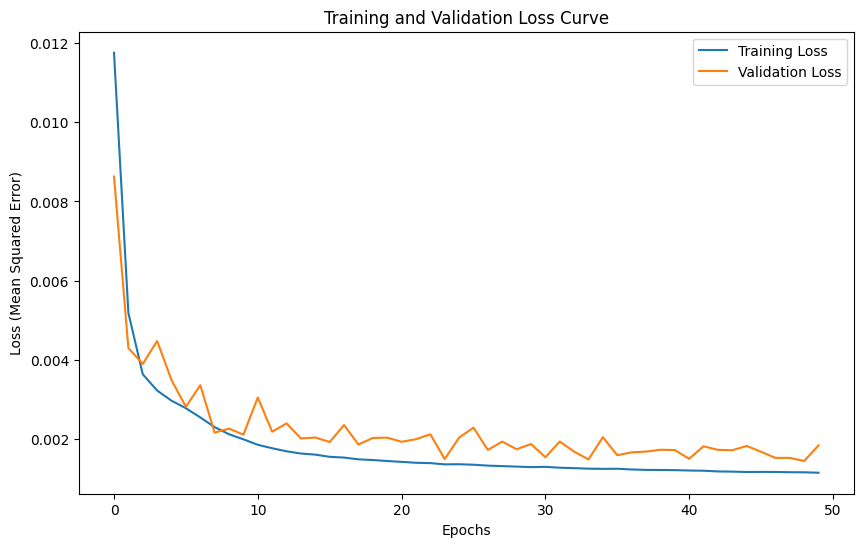

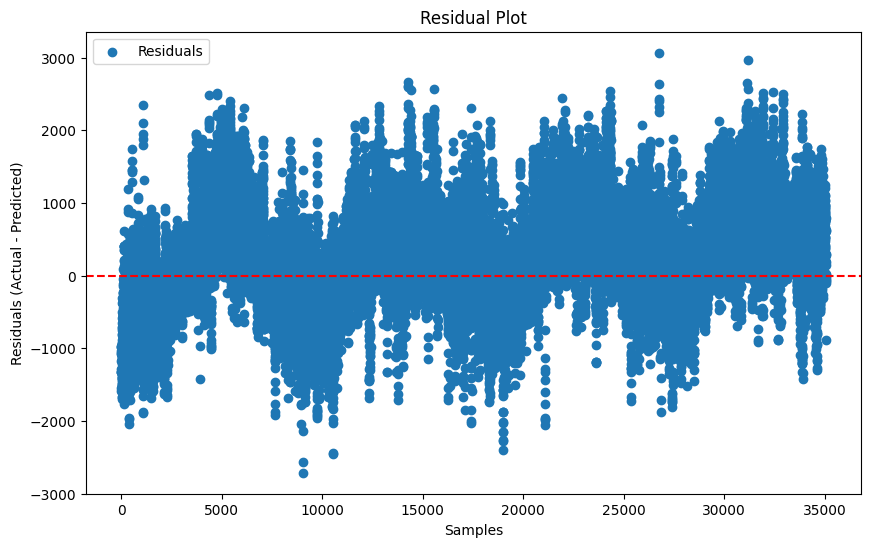

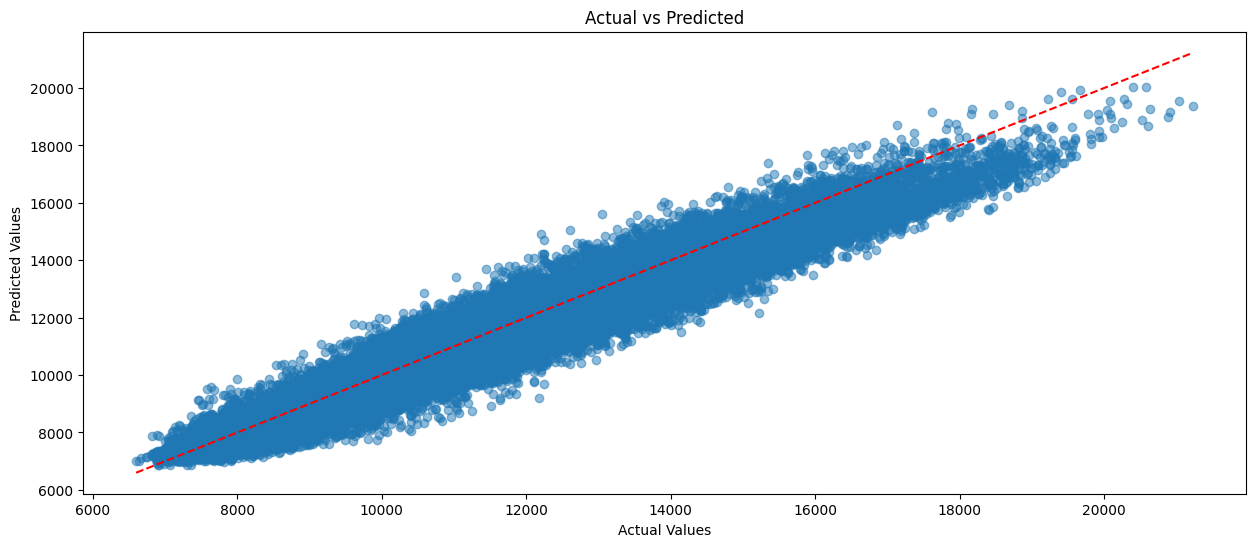

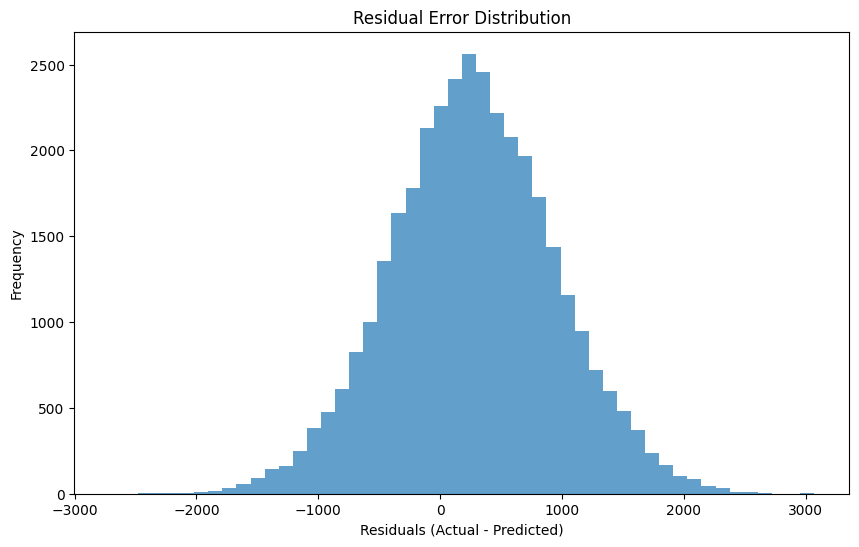

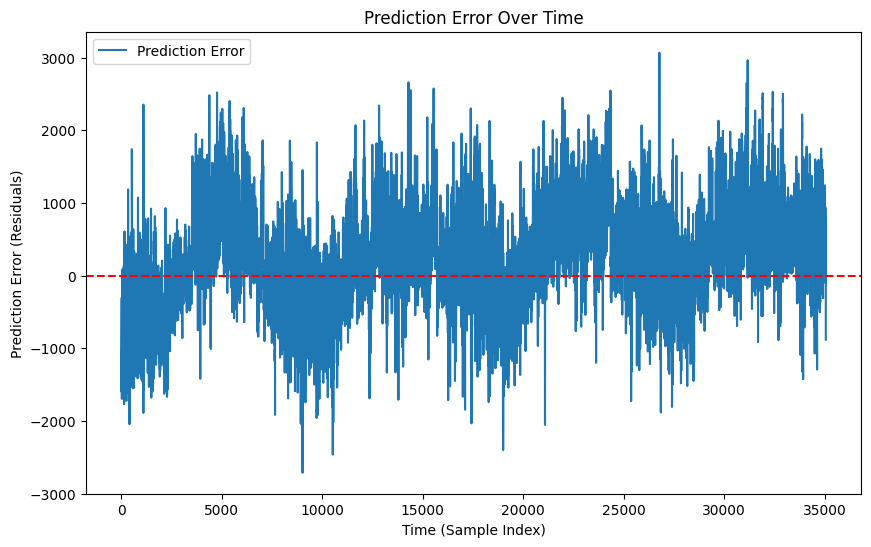

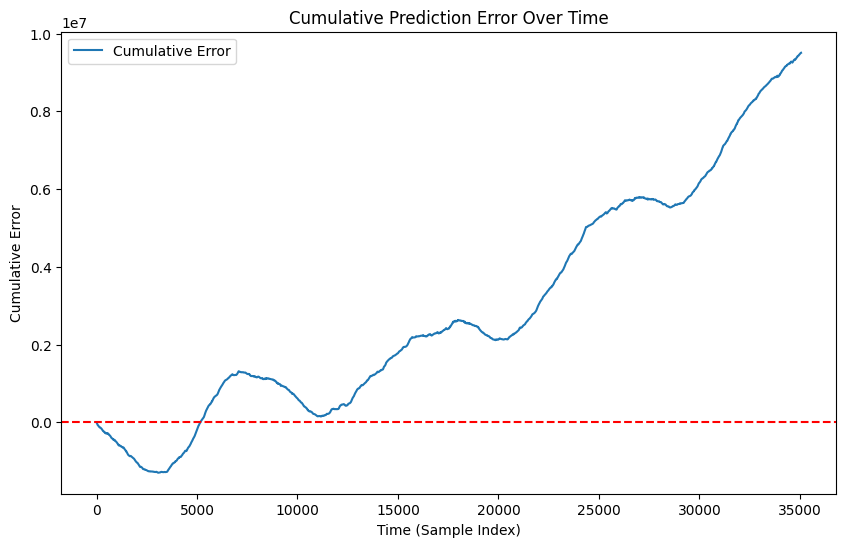

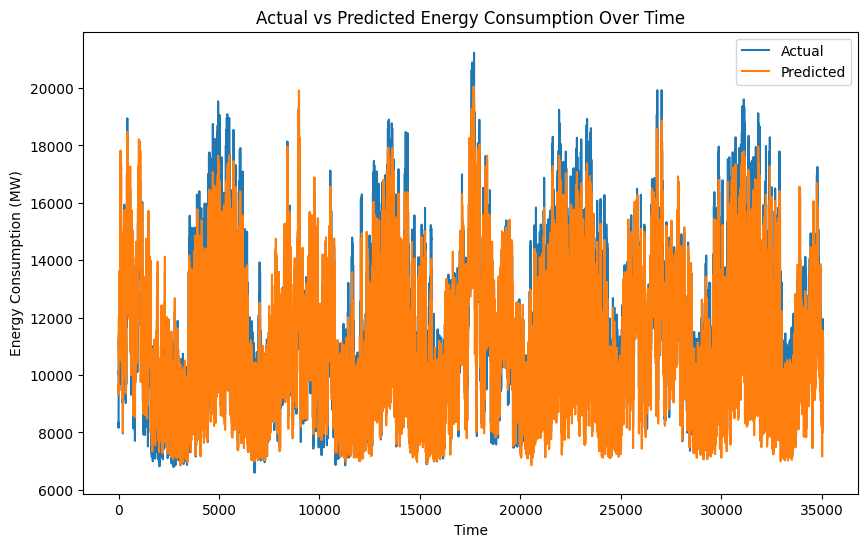

In [18]:
# Additional code for evaluation and plotting can be reused here

# 8.1 Loss Curve
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.show()

# 8.2 Residual Plot
residuals = y_test_inv - test_predictions_inv
plt.figure(figsize=(10,6))
plt.scatter(range(len(residuals)), residuals, label='Residuals')
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Samples')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

# 8.3 Actual vs Predicted Scatter Plot
plt.figure(figsize=(15,6))
plt.scatter(y_test_inv, test_predictions_inv, alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')  # Perfect fit line
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Additional diagnostic plots (same as your provided code):
# 8.4 Error Distribution (Histogram)
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Residual Error Distribution')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

# 8.5 Prediction Error Over Time
plt.figure(figsize=(10,6))
plt.plot(residuals, label='Prediction Error')
plt.title('Prediction Error Over Time')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Prediction Error (Residuals)')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

# 8.6 Cumulative Prediction Error
cumulative_error = np.cumsum(residuals)
plt.figure(figsize=(10,6))
plt.plot(cumulative_error, label='Cumulative Error')
plt.title('Cumulative Prediction Error Over Time')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Cumulative Error')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

# 8.7 Actual vs Predicted Over Time
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_predictions_inv, label='Predicted')
plt.title('Actual vs Predicted Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

## hp 2

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras_tuner import RandomSearch
from keras.optimizers import Adam

# Step 1: Data Preparation
split_date = '2016-01-01'
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

# Dropping unnecessary columns for features
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Scale the data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input to be [samples, time steps, features] for LSTM
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Step 2: Define and Build the LSTM Model using Keras Tuner
def build_model(hp):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(units=hp.Int('units_1', min_value=50, max_value=150, step=50),
                   return_sequences=True,
                   input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.4, step=0.1)))

    # Second LSTM layer
    model.add(LSTM(units=hp.Int('units_2', min_value=50, max_value=150, step=50),
                   return_sequences=True))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.4, step=0.1)))

    # Third LSTM layer
    model.add(LSTM(units=hp.Int('units_3', min_value=50, max_value=150, step=50)))
    model.add(Dropout(hp.Float('dropout_3', 0.1, 0.4, step=0.1)))

    # Dense output layer
    model.add(Dense(units=1))

    # Compile model
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='mean_squared_error')

    return model

# Step 3: Initialize the Tuner (with reduced trials for computational resources)
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=2,  # Reduced number of trials for faster tuning
    executions_per_trial=1,  # Number of models to train for each trial
    directory='lstm_tuning',
    project_name='energy_consumption_forecasting'
)

# Step 4: Run the Hyperparameter Search (with reduced epochs)
tuner.search(X_train_scaled, y_train_scaled,
             epochs=100,  # Reduced epochs to save computational time
             validation_data=(X_test_scaled, y_test_scaled),
             #batch_size=128,  # Fixed batch size - remove this line
             verbose=1)

# Step 5: Retrieve the Best Hyperparameters and Build the Best Model
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_scaled, y_train_scaled,
                         epochs=100,  # Reduced epochs
                         batch_size=128,  # Fixed batch size - add this line back
                         validation_data=(X_test_scaled, y_test_scaled),
                         verbose=1)

# Step 6: Save the model for future use
model_path = 'best_lstm_model100.h5'
best_model.save(model_path)
print(f"Model saved to {model_path}")

# Step 7: Make Predictions and Evaluate the Model
train_predictions = best_model.predict(X_train_scaled)
test_predictions = best_model.predict(X_test_scaled)

# Inverse transform predictions and true values
train_predictions_inv = scaler_y.inverse_transform(train_predictions)
test_predictions_inv = scaler_y.inverse_transform(test_predictions)
y_train_inv = scaler_y.inverse_transform(y_train_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)

# Evaluate the Model
rmse = mean_squared_error(y_test_inv, test_predictions_inv, squared=False)
mae = mean_absolute_error(y_test_inv, test_predictions_inv)
mape = mean_absolute_percentage_error(y_test_inv, test_predictions_inv)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

# Step 8: Load the saved model for future use
def load_trained_model(model_path):
    model = load_model(model_path)
    print("Model loaded successfully.")
    return model

# Example of loading and using the saved model
loaded_model = load_trained_model('best_lstm_model100.h5')

# Evaluate the loaded model with test data
loaded_test_predictions = loaded_model.predict(X_test_scaled)
loaded_test_predictions_inv = scaler_y.inverse_transform(loaded_test_predictions)

# Step 9: Evaluate the loaded model
rmse_loaded = mean_squared_error(y_test_inv, loaded_test_predictions_inv, squared=False)
mae_loaded = mean_absolute_error(y_test_inv, loaded_test_predictions_inv)
mape_loaded = mean_absolute_percentage_error(y_test_inv, loaded_test_predictions_inv)

print(f"Loaded Model RMSE: {rmse_loaded}")
print(f"Loaded Model MAE: {mae_loaded}")
print(f"Loaded Model MAPE: {mape_loaded}")


Reloading Tuner from lstm_tuning/energy_consumption_forecasting/tuner0.json
Best Hyperparameters: {'units_1': 150, 'dropout_1': 0.30000000000000004, 'units_2': 50, 'dropout_2': 0.1, 'units_3': 100, 'dropout_3': 0.30000000000000004, 'learning_rate': 0.0014849757124240257}
Epoch 1/100


685/685 ━━━━━━━━━━━━━━━━━━━━ 18s 19ms/step - loss: 0.0216 - val_loss: 0.0067
Epoch 2/100
685/685 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0058 - val_loss: 0.0034
Epoch 3/100
685/685 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 4/100
685/685 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0033 - val_loss: 0.0035
Epoch 5/100
685/685 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0031 - val_loss: 0.0033
Epoch 6/100
685/685 ━━━━━━━━━━━━━━━━━━━━ 20s 19ms/step - loss: 0.0028 - val_loss: 0.0032
Epoch 7/100
685/685 ━━━━━━━━━━━━━━━━━━━━ 13s 18ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 8/100
685/685 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 9/100
685/685 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 10/100
685/685 ━━━━━━━━━━━━━━━━━━━━ 21s 20ms/step - loss: 0.0019 - val_loss: 0.0022
Epoch 11/100
685/685 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 12/100
685/685 ━━━━━━━━━━

Model saved to best_lstm_model100.h5
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


RMSE: 780.4460975959156
MAE: 629.9184678429533
MAPE: 0.05557423172481009
Model loaded successfully.
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
Loaded Model RMSE: 780.4460975959156
Loaded Model MAE: 629.9184678429533
Loaded Model MAPE: 0.05557423172481009


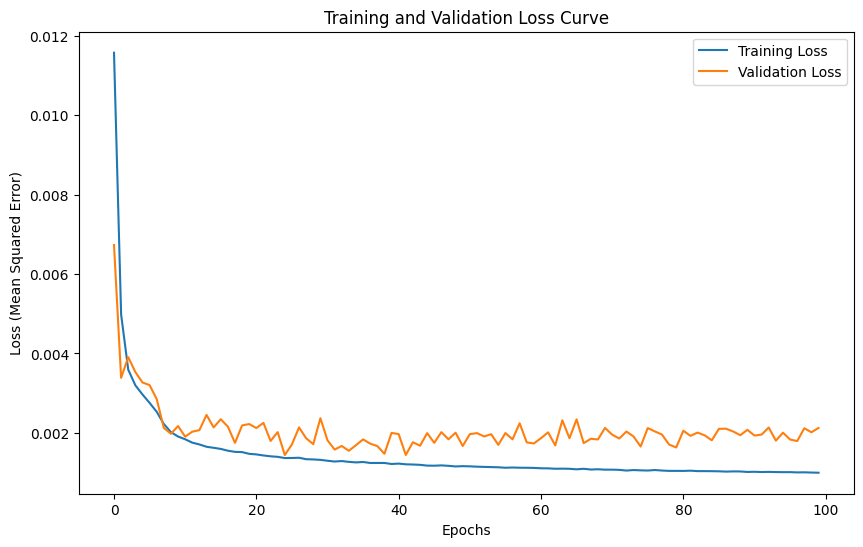

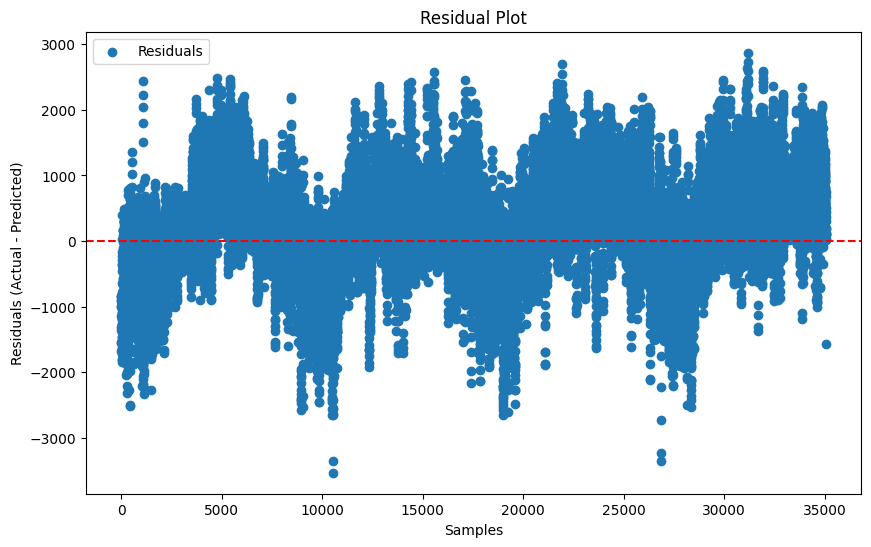

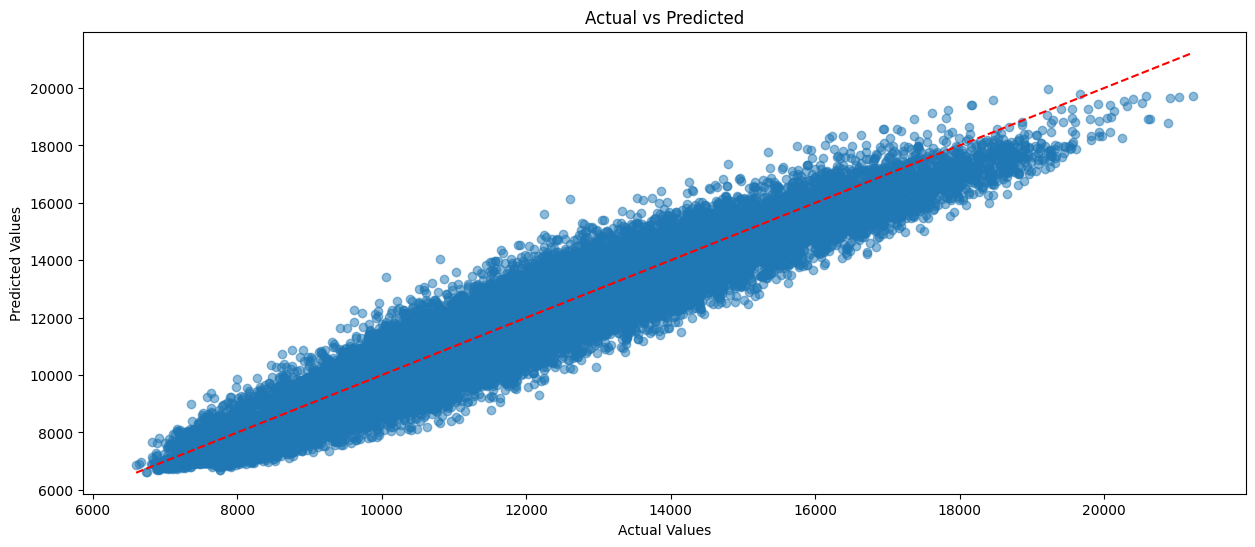

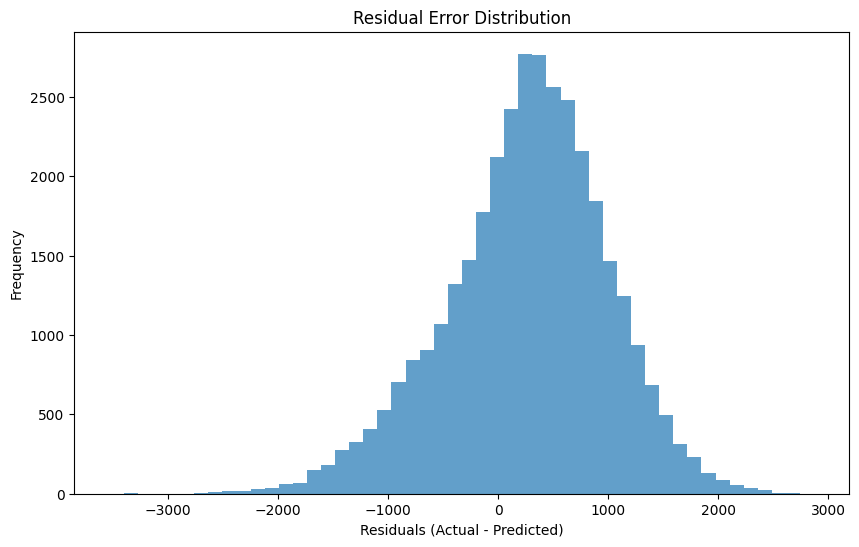

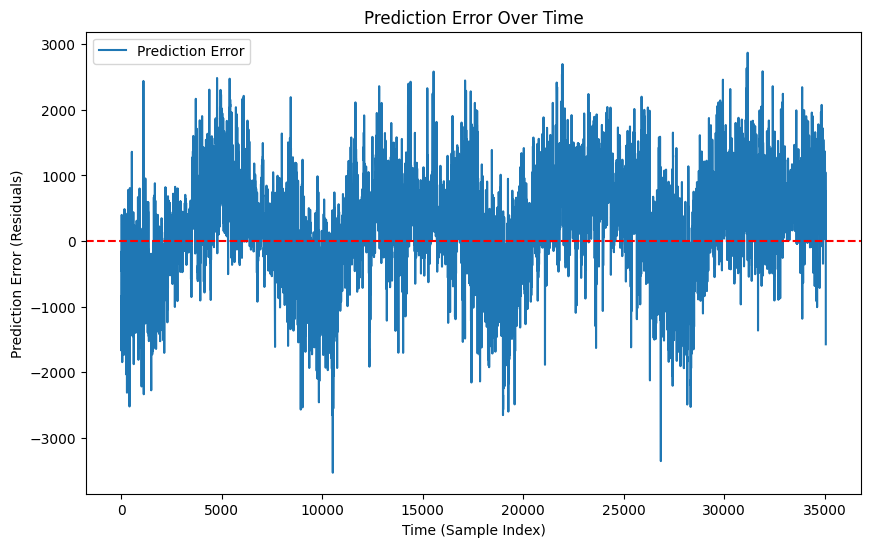

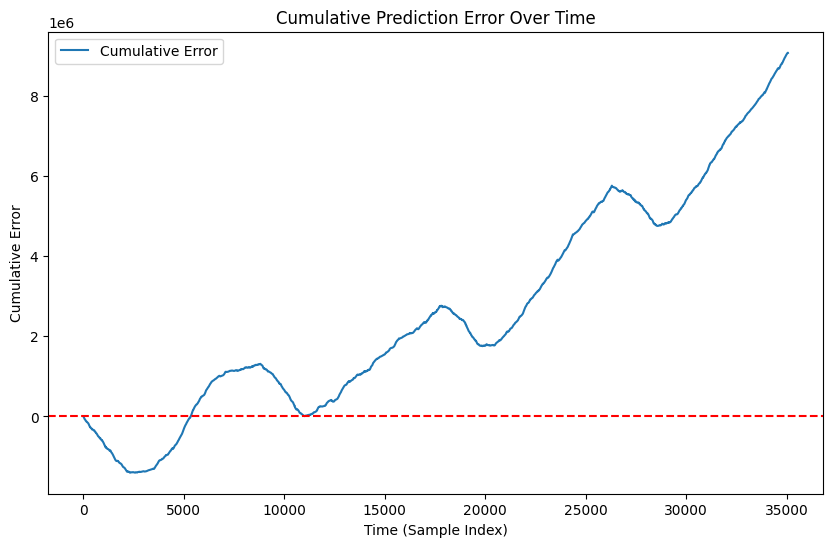

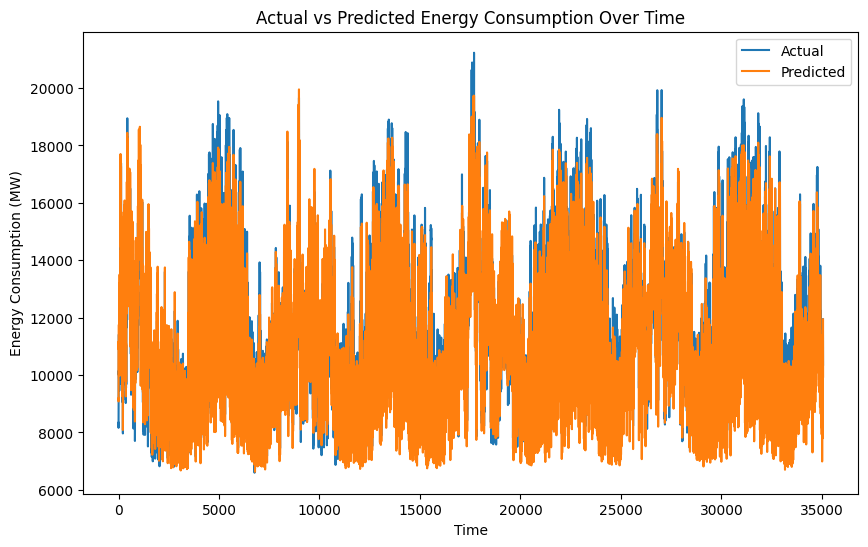

In [20]:
# Additional code for evaluation and plotting can be reused here

# 8.1 Loss Curve
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.show()

# 8.2 Residual Plot
residuals = y_test_inv - test_predictions_inv
plt.figure(figsize=(10,6))
plt.scatter(range(len(residuals)), residuals, label='Residuals')
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Samples')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

# 8.3 Actual vs Predicted Scatter Plot
plt.figure(figsize=(15,6))
plt.scatter(y_test_inv, test_predictions_inv, alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')  # Perfect fit line
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Additional diagnostic plots (same as your provided code):
# 8.4 Error Distribution (Histogram)
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Residual Error Distribution')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

# 8.5 Prediction Error Over Time
plt.figure(figsize=(10,6))
plt.plot(residuals, label='Prediction Error')
plt.title('Prediction Error Over Time')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Prediction Error (Residuals)')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

# 8.6 Cumulative Prediction Error
cumulative_error = np.cumsum(residuals)
plt.figure(figsize=(10,6))
plt.plot(cumulative_error, label='Cumulative Error')
plt.title('Cumulative Prediction Error Over Time')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Cumulative Error')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

# 8.7 Actual vs Predicted Over Time
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_predictions_inv, label='Predicted')
plt.title('Actual vs Predicted Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

## hp 3

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras_tuner import RandomSearch
from keras.optimizers import Adam

# Step 1: Data Preparation
split_date = '2016-01-01'
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

# Dropping unnecessary columns for features
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Scale the data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input to be [samples, time steps, features] for LSTM
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Step 2: Define and Build the LSTM Model using Keras Tuner
def build_model(hp):
    model = Sequential()

    # First LSTM layer
    model.add(LSTM(units=hp.Int('units_1', min_value=50, max_value=150, step=50),
                   return_sequences=True,
                   input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(hp.Float('dropout_1', 0.1, 0.4, step=0.1)))

    # Second LSTM layer
    model.add(LSTM(units=hp.Int('units_2', min_value=50, max_value=150, step=50),
                   return_sequences=True))
    model.add(Dropout(hp.Float('dropout_2', 0.1, 0.4, step=0.1)))

    # Third LSTM layer
    model.add(LSTM(units=hp.Int('units_3', min_value=50, max_value=150, step=50)))
    model.add(Dropout(hp.Float('dropout_3', 0.1, 0.4, step=0.1)))

    # Dense output layer
    model.add(Dense(units=1))

    # Compile model
    model.compile(optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
                  loss='mean_squared_error')

    return model

# Step 3: Initialize the Tuner (with reduced trials for computational resources)
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=2,  # Reduced number of trials for faster tuning
    executions_per_trial=1,  # Number of models to train for each trial
    directory='lstm_tuning',
    project_name='energy_consumption_forecasting'
)

# Step 4: Run the Hyperparameter Search (with reduced epochs)
tuner.search(X_train_scaled, y_train_scaled,
             epochs=50,  # Reduced epochs to save computational time
             validation_data=(X_test_scaled, y_test_scaled),
             #batch_size=128,  # Fixed batch size - remove this line
             verbose=1)

# Step 5: Retrieve the Best Hyperparameters and Build the Best Model
best_hps = tuner.get_best_hyperparameters()[0]
print(f"Best Hyperparameters: {best_hps.values}")

# Build the best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train_scaled, y_train_scaled,
                         epochs=50,  # Reduced epochs
                         batch_size=1000,  # Fixed batch size - add this line back
                         validation_data=(X_test_scaled, y_test_scaled),
                         verbose=1)

# Step 6: Save the model for future use
model_path = 'best_lstm_model3.h5'
best_model.save(model_path)
print(f"Model saved to {model_path}")

# Step 7: Make Predictions and Evaluate the Model
train_predictions = best_model.predict(X_train_scaled)
test_predictions = best_model.predict(X_test_scaled)

# Inverse transform predictions and true values
train_predictions_inv = scaler_y.inverse_transform(train_predictions)
test_predictions_inv = scaler_y.inverse_transform(test_predictions)
y_train_inv = scaler_y.inverse_transform(y_train_scaled)
y_test_inv = scaler_y.inverse_transform(y_test_scaled)

# Evaluate the Model
rmse = mean_squared_error(y_test_inv, test_predictions_inv, squared=False)
mae = mean_absolute_error(y_test_inv, test_predictions_inv)
mape = mean_absolute_percentage_error(y_test_inv, test_predictions_inv)

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}")

# Step 8: Load the saved model for future use
def load_trained_model(model_path):
    model = load_model(model_path)
    print("Model loaded successfully.")
    return model

# Example of loading and using the saved model
loaded_model = load_trained_model('best_lstm_model3.h5')

# Evaluate the loaded model with test data
loaded_test_predictions = loaded_model.predict(X_test_scaled)
loaded_test_predictions_inv = scaler_y.inverse_transform(loaded_test_predictions)

# Step 9: Evaluate the loaded model
rmse_loaded = mean_squared_error(y_test_inv, loaded_test_predictions_inv, squared=False)
mae_loaded = mean_absolute_error(y_test_inv, loaded_test_predictions_inv)
mape_loaded = mean_absolute_percentage_error(y_test_inv, loaded_test_predictions_inv)

print(f"Loaded Model RMSE: {rmse_loaded}")
print(f"Loaded Model MAE: {mae_loaded}")
print(f"Loaded Model MAPE: {mape_loaded}")


Reloading Tuner from lstm_tuning/energy_consumption_forecasting/tuner0.json
Best Hyperparameters: {'units_1': 150, 'dropout_1': 0.30000000000000004, 'units_2': 50, 'dropout_2': 0.1, 'units_3': 100, 'dropout_3': 0.30000000000000004, 'learning_rate': 0.0014849757124240257}


Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - loss: 0.0595 - val_loss: 0.0137
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.0113 - val_loss: 0.0099
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.0096 - val_loss: 0.0092
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - loss: 0.0090 - val_loss: 0.0086
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0082 - val_loss: 0.0071
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0071 - val_loss: 0.0065
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0063 - val_loss: 0.0057
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 6s 70ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 9/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0052 - val_loss: 0.0048
Epoch 10/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 11/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 12/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.

Model saved to best_lstm_model3.h5
2740/2740 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


RMSE: 748.3662231256739
MAE: 584.9943495404162
MAPE: 0.051195286491192295
Model loaded successfully.
1096/1096 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
Loaded Model RMSE: 748.3662231256739
Loaded Model MAE: 584.9943495404162
Loaded Model MAPE: 0.051195286491192295


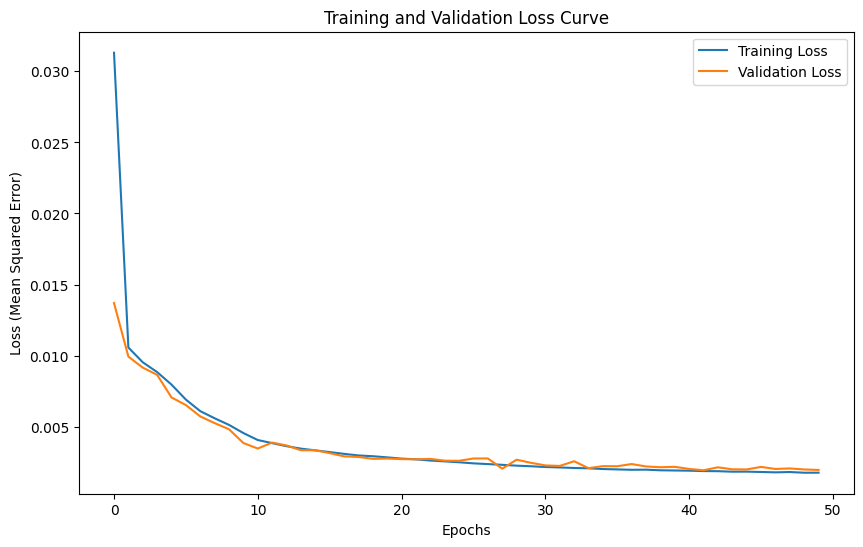

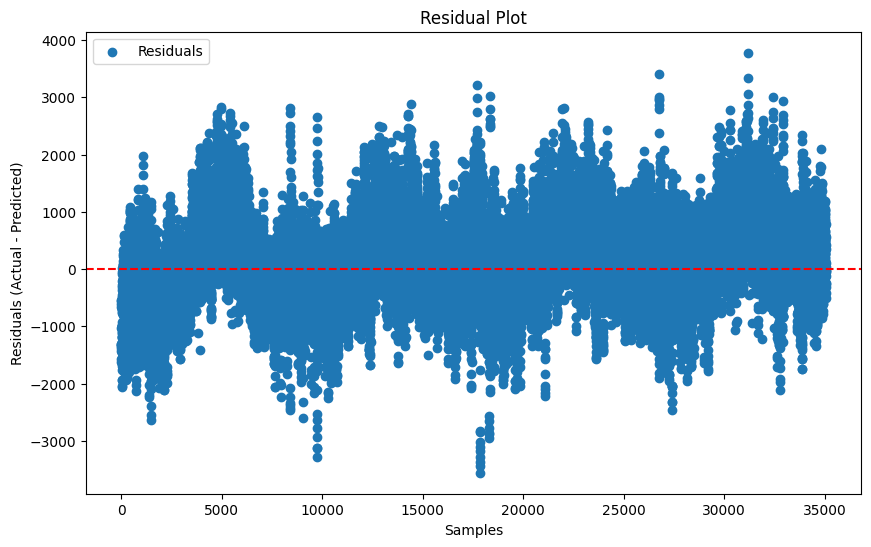

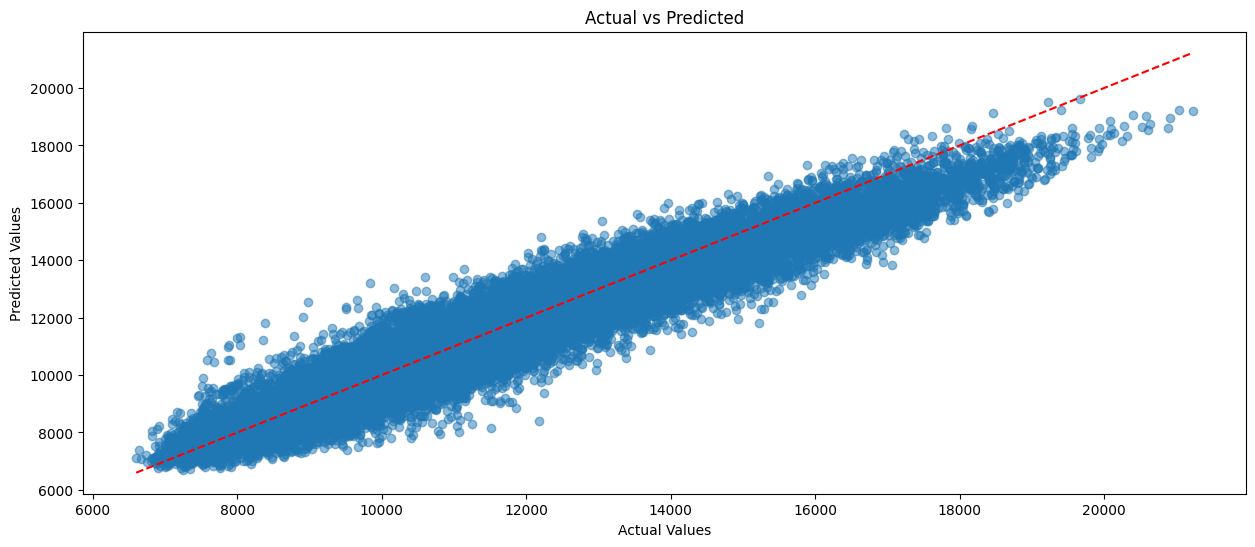

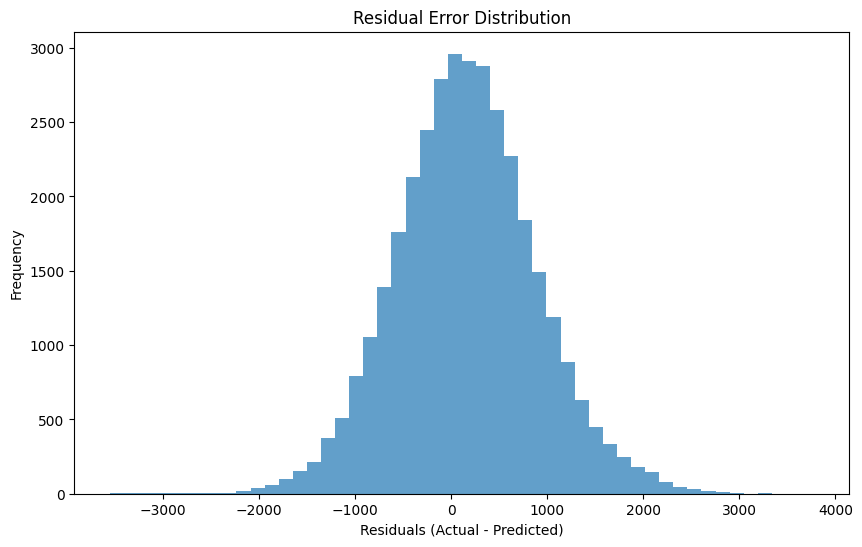

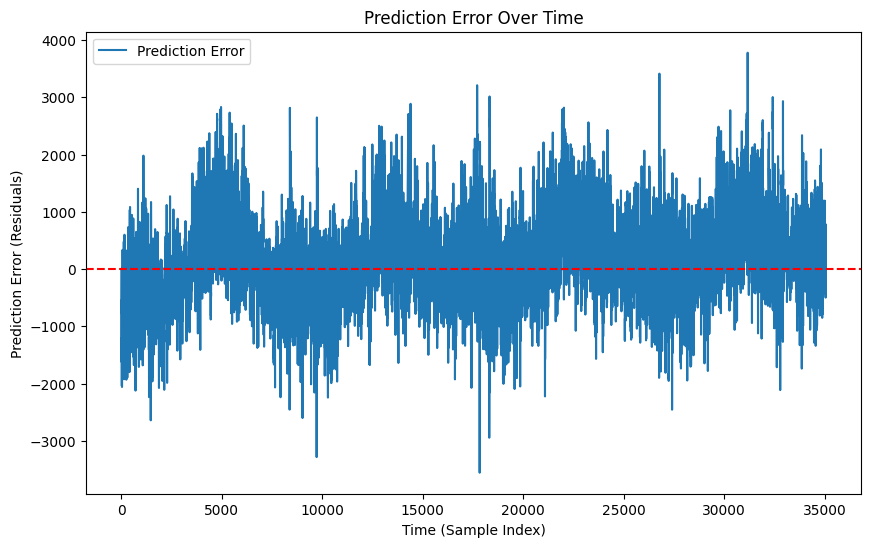

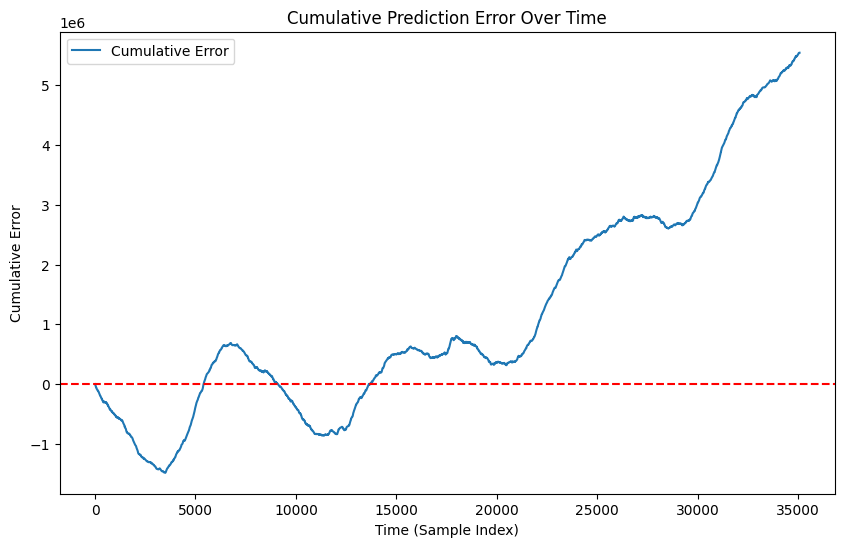

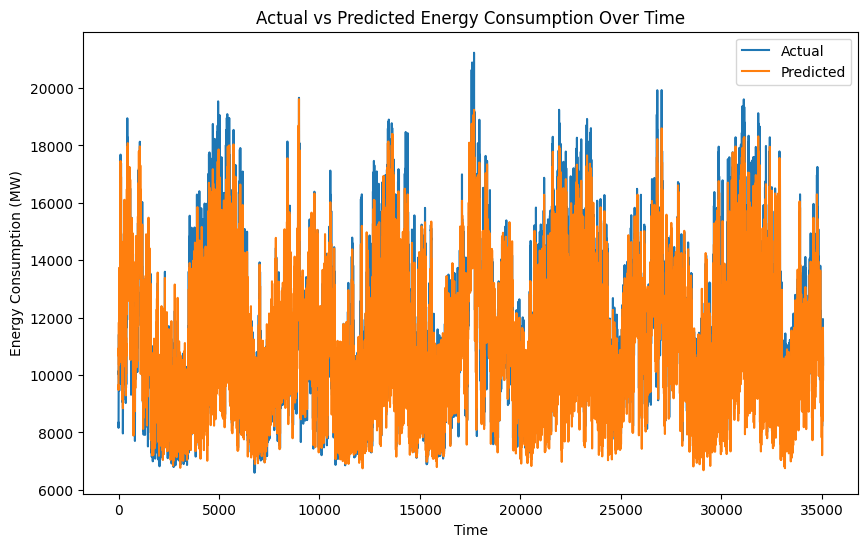

In [22]:
# Additional code for evaluation and plotting can be reused here

# 8.1 Loss Curve
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (Mean Squared Error)')
plt.legend()
plt.show()

# 8.2 Residual Plot
residuals = y_test_inv - test_predictions_inv
plt.figure(figsize=(10,6))
plt.scatter(range(len(residuals)), residuals, label='Residuals')
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Samples')
plt.ylabel('Residuals (Actual - Predicted)')
plt.legend()
plt.show()

# 8.3 Actual vs Predicted Scatter Plot
plt.figure(figsize=(15,6))
plt.scatter(y_test_inv, test_predictions_inv, alpha=0.5)
plt.plot([y_test_inv.min(), y_test_inv.max()], [y_test_inv.min(), y_test_inv.max()], 'r--')  # Perfect fit line
plt.title('Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

# Additional diagnostic plots (same as your provided code):
# 8.4 Error Distribution (Histogram)
plt.figure(figsize=(10,6))
plt.hist(residuals, bins=50, alpha=0.7)
plt.title('Residual Error Distribution')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.show()

# 8.5 Prediction Error Over Time
plt.figure(figsize=(10,6))
plt.plot(residuals, label='Prediction Error')
plt.title('Prediction Error Over Time')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Prediction Error (Residuals)')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

# 8.6 Cumulative Prediction Error
cumulative_error = np.cumsum(residuals)
plt.figure(figsize=(10,6))
plt.plot(cumulative_error, label='Cumulative Error')
plt.title('Cumulative Prediction Error Over Time')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Cumulative Error')
plt.axhline(0, color='r', linestyle='--')
plt.legend()
plt.show()

# 8.7 Actual vs Predicted Over Time
plt.figure(figsize=(10,6))
plt.plot(y_test_inv, label='Actual')
plt.plot(test_predictions_inv, label='Predicted')
plt.title('Actual vs Predicted Energy Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Energy Consumption (MW)')
plt.legend()
plt.show()

# Result Collection

In [ ]:
# Load the MLP models
lstm_model1 = load_model('/content/lstm_energy_model1.h5')
lstm_model2 = load_model('/content/lstm_energy_model2.h5')
lstm_hp1 = load_model('/content/best_lstm_model.h5')
lstm_hp2 = load_model('/content/best_lstm_model100.h5')

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dropout, Dense
from keras_tuner import RandomSearch
from keras.optimizers import Adam

# Step 1: Data Preparation
split_date = '2016-01-01'
train = data_till_2019.loc[data_till_2019['datetime'] <= split_date].copy()
test = data_till_2019.loc[data_till_2019['datetime'] > split_date].copy()

# Dropping unnecessary columns for features
train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Scale the data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input to be [samples, time steps, features] for LSTM
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
lstm_model1 Evaluation
RMSE: 673.9401807869086
MAE: 528.4659374922016
MAPE: 0.0464132236519554
R^2: 0.9240573463750223



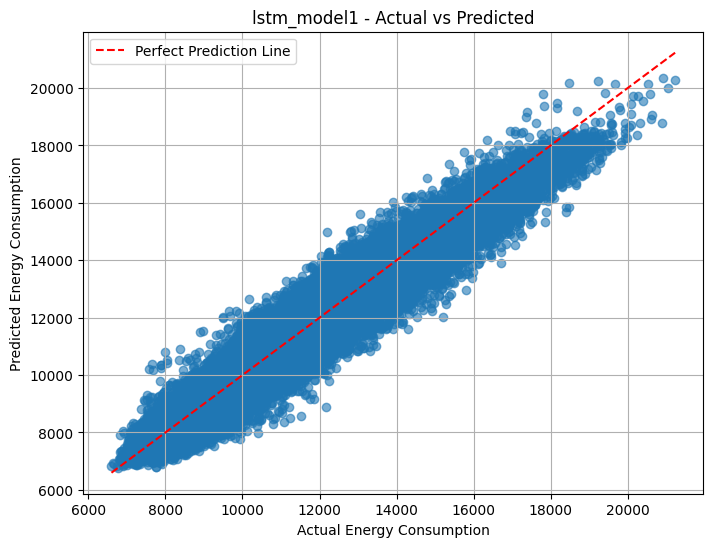

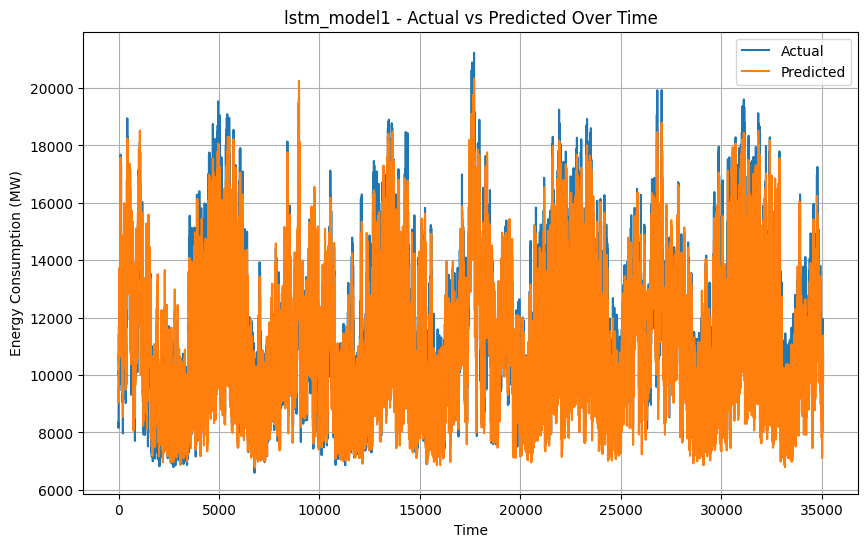

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
lstm_model2 Evaluation
RMSE: 717.0632353225442
MAE: 565.1929325689498
MAPE: 0.04897829299971247
R^2: 0.9140278117866761



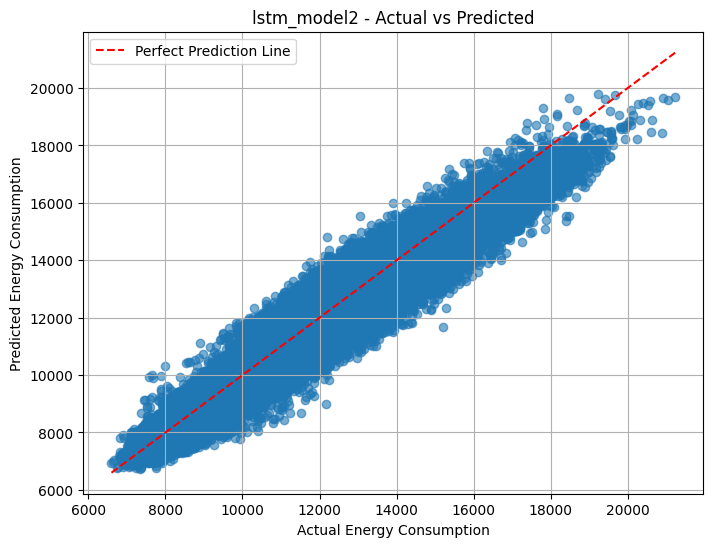

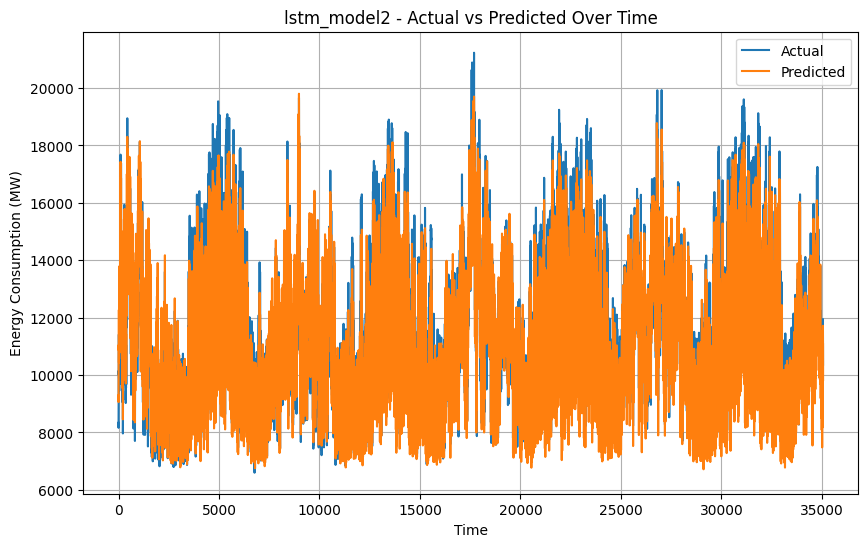

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
lstm_hp1 Evaluation
RMSE: 727.5661749933506
MAE: 576.640429736072
MAPE: 0.049706532162337495
R^2: 0.9114908706462955



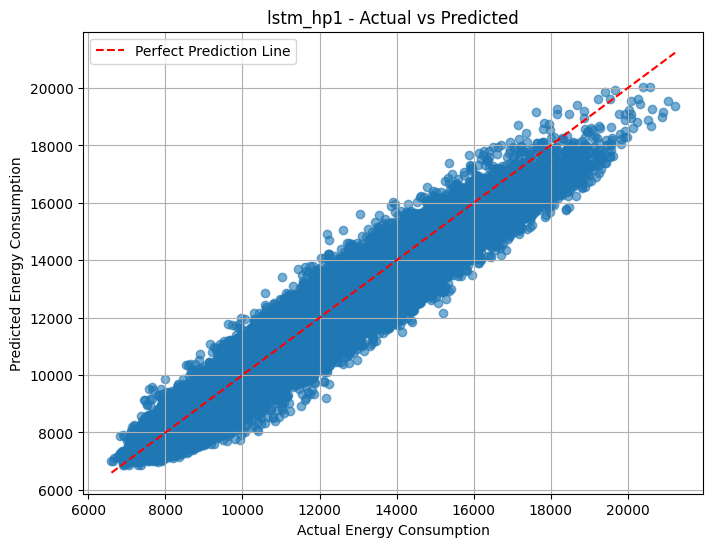

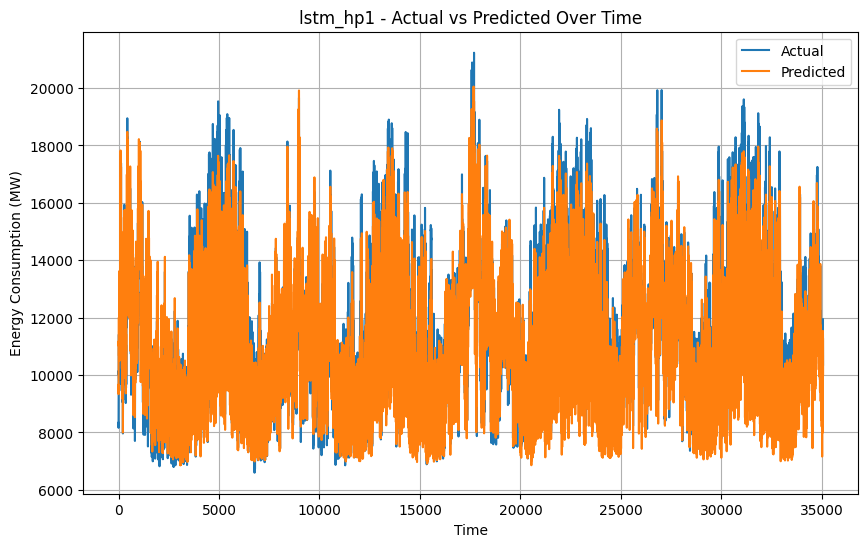

1096/1096 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
lstm_hp2 Evaluation
RMSE: 780.4460975959156
MAE: 629.9184678429533
MAPE: 0.05557423172481009
R^2: 0.8981575367483638



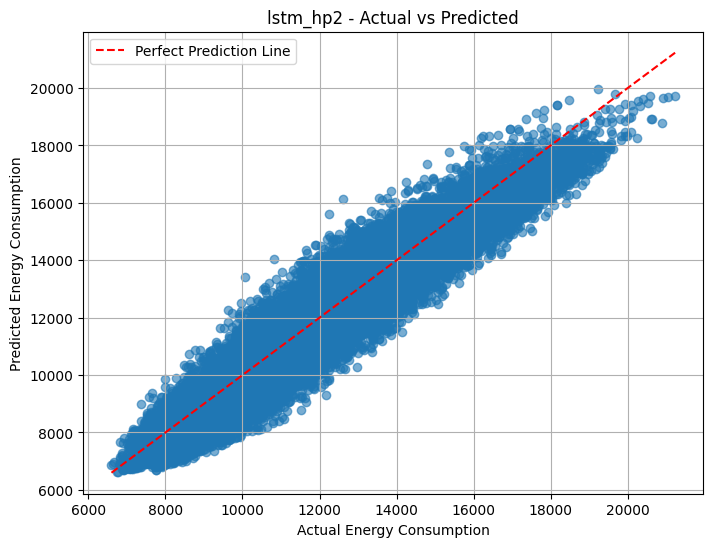

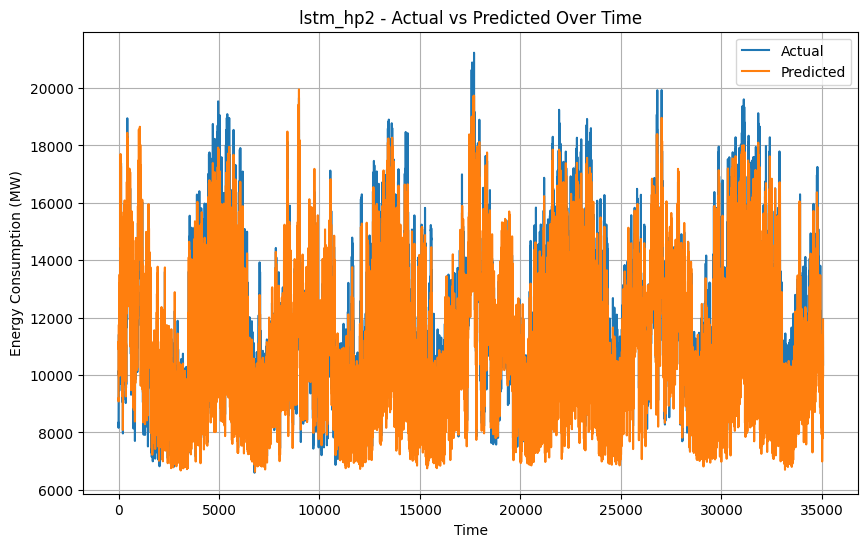

Evaluation results and predictions exported successfully!


In [15]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

# Function to evaluate and plot model results
def evaluate_and_plot_model(model_name, model, X_test_scaled, y_test_inv, y_test, scaler_y):
    # Make predictions using the model
    predictions_scaled = model.predict(X_test_scaled)
    predictions = scaler_y.inverse_transform(predictions_scaled)

    # Calculate evaluation metrics
    rmse = mean_squared_error(y_test_inv, predictions, squared=False)
    mae = mean_absolute_error(y_test_inv, predictions)
    mape = mean_absolute_percentage_error(y_test_inv, predictions)
    r2 = r2_score(y_test_inv, predictions)

    print(f"{model_name} Evaluation")
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"R^2: {r2}\n")

    # Return evaluation metrics for DataFrame storage
    return [model_name, mape, mae, rmse, r2], predictions

# Function to create scatter plot for true vs predicted
def plot_scatter_true_vs_pred(y_test_inv, predictions, model_name):
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test_inv, predictions, alpha=0.6)
    plt.plot([min(y_test_inv), max(y_test_inv)], [min(y_test_inv), max(y_test_inv)], color='red', linestyle='--', label='Perfect Prediction Line')
    plt.xlabel('Actual Energy Consumption')
    plt.ylabel('Predicted Energy Consumption')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to create line plot for true vs predicted over time
def plot_line_true_vs_pred(y_test_inv, predictions, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test_inv, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MW)')
    plt.title(f'{model_name} - Actual vs Predicted Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define list to store evaluation results for DataFrame
evaluation_results = []

# Load and evaluate all LSTM models
models = {
    'lstm_model1': load_model('/content/lstm_energy_model1.h5'),
    'lstm_model2': load_model('/content/lstm_energy_model2.h5'),
    'lstm_hp1': load_model('/content/best_lstm_model.h5'),
    'lstm_hp2': load_model('/content/best_lstm_model100.h5')
}

# Assuming X_test_scaled, y_test_scaled, and the datetime column are already defined
# Rescale the data back to original for comparison
y_test_inv = scaler_y.inverse_transform(y_test_scaled)

# Initialize a DataFrame to store actuals and predictions for all models
# Instead of test['datetime'], we use the 'datetime' column from the test DataFrame directly
combined_results_df = pd.DataFrame({'datetime': test['datetime'], 'Actual': y_test_inv.flatten()})

# Iterate over each model for evaluation and plotting
for model_name, model in models.items():
    # Evaluate model and get predictions
    eval_metrics, predictions = evaluate_and_plot_model(model_name, model, X_test_scaled, y_test_inv, y_test_scaled, scaler_y)

    # Store evaluation metrics
    evaluation_results.append(eval_metrics)

    # Add predictions to the combined DataFrame
    combined_results_df[f'{model_name}_Predicted'] = predictions.flatten()

    # Plot scatter and line plots
    plot_scatter_true_vs_pred(y_test_inv, predictions, model_name)
    plot_line_true_vs_pred(y_test_inv, predictions, model_name)

# Export all actuals and predictions to a single CSV with datetime as index
combined_results_df.set_index('datetime', inplace=True)
combined_results_df.to_csv('/content/lstm_models_predictions_vs_actuals.csv')

# Create a DataFrame for all evaluations and export as CSV
evaluation_df = pd.DataFrame(evaluation_results, columns=['Model', 'MAPE', 'MAE', 'RMSE', 'R2'])
evaluation_df.to_csv('/content/lstm_results_evaluation.csv', index=False)

print("Evaluation results and predictions exported successfully!")


# CASE STUDY

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 86ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step

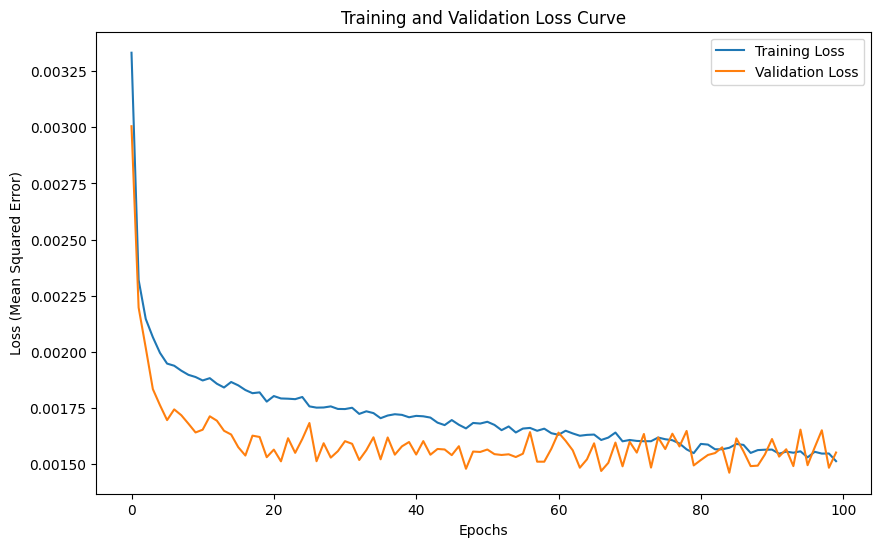

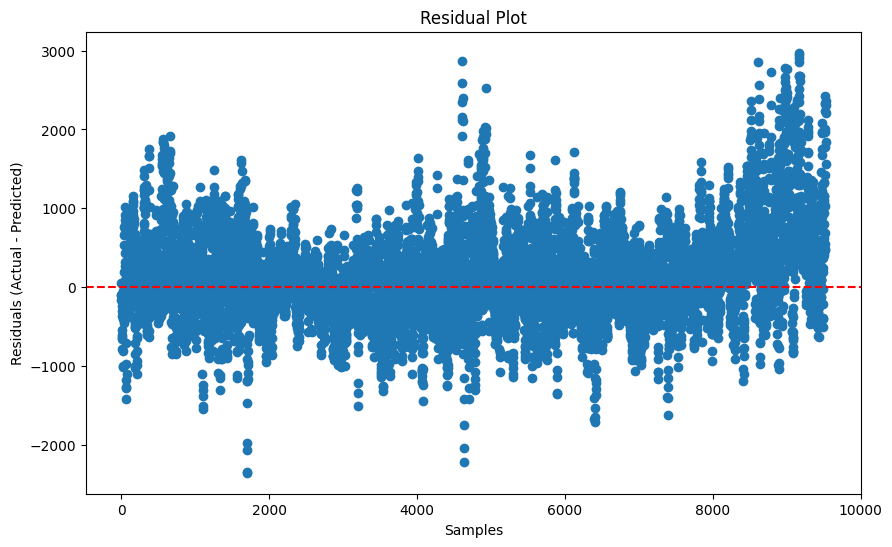

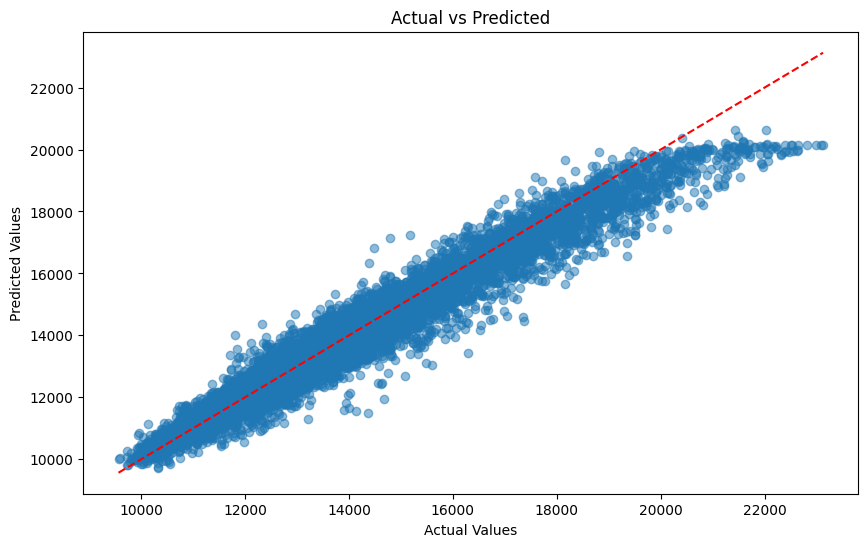

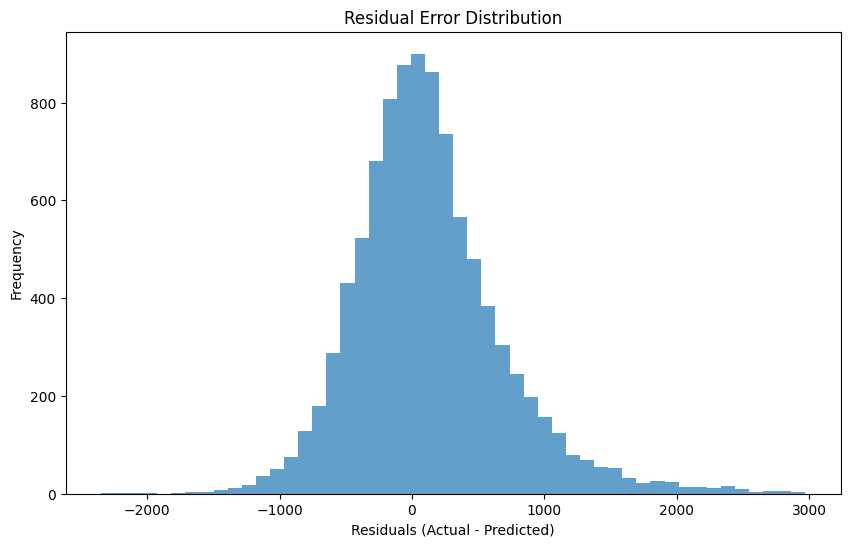

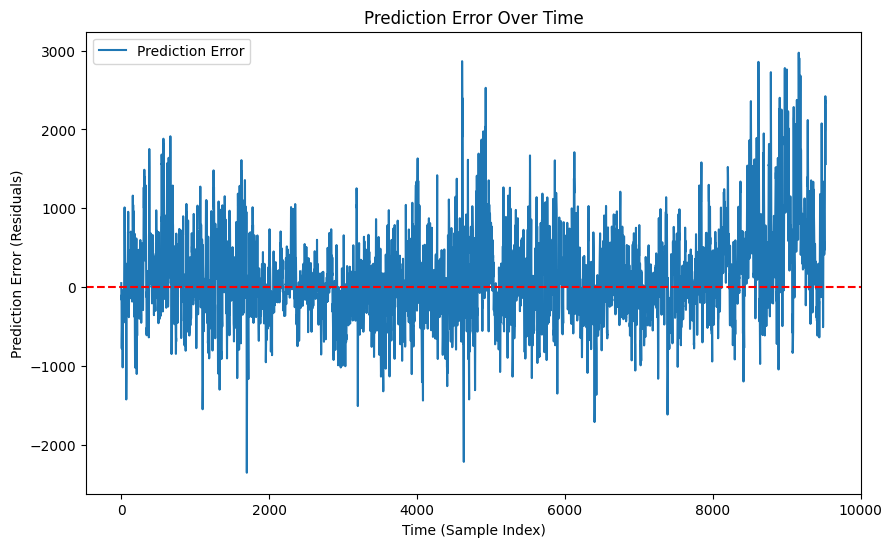

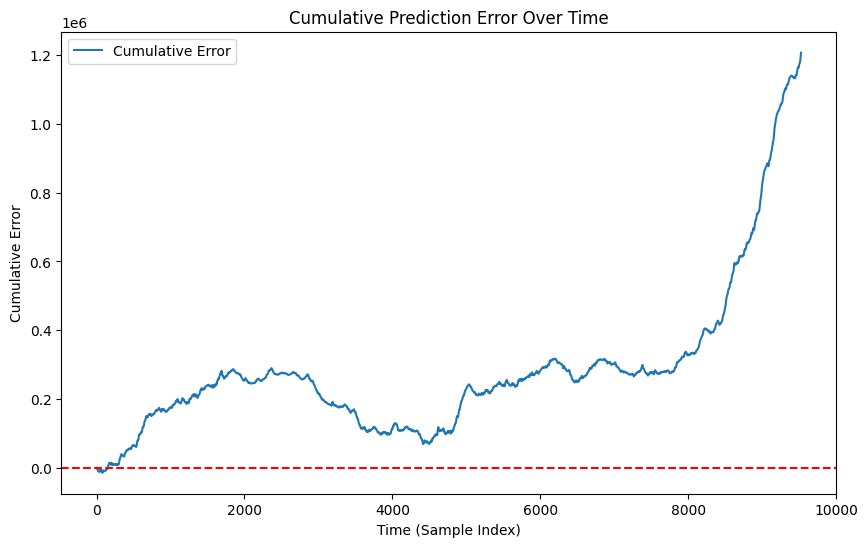

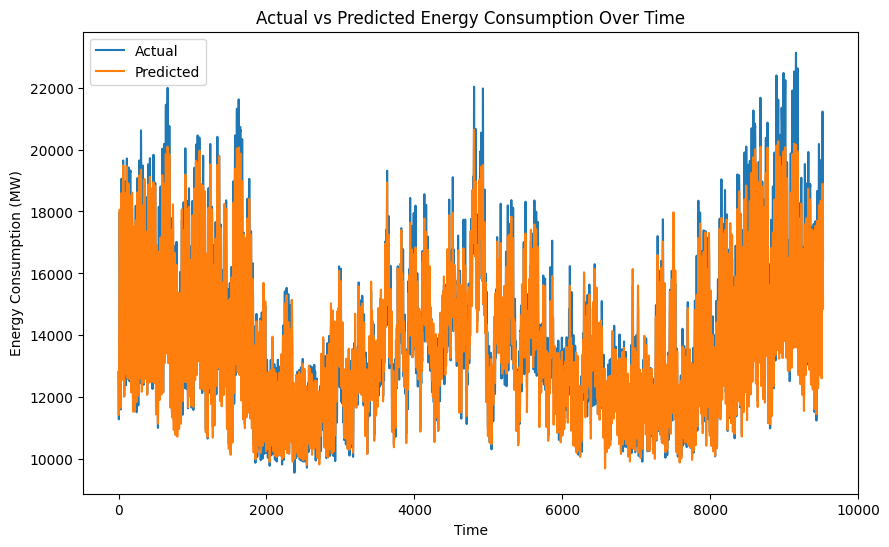

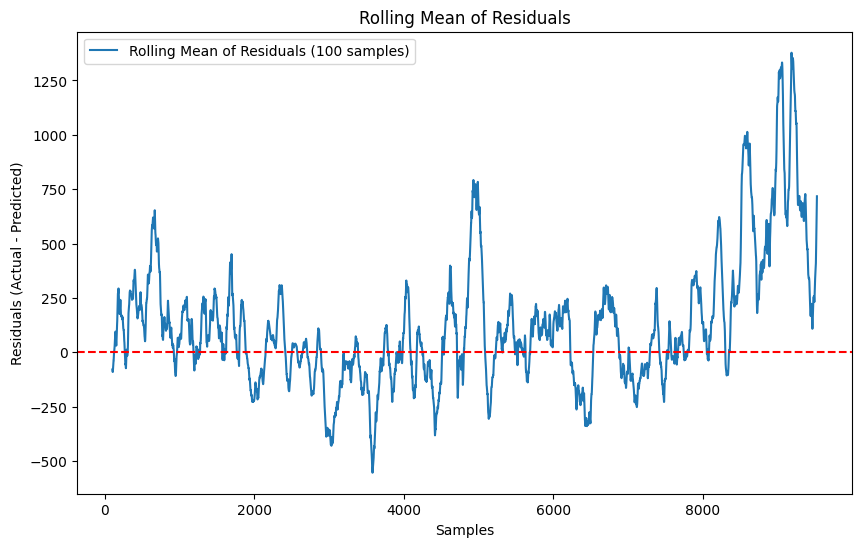

<Figure size 1000x600 with 0 Axes>

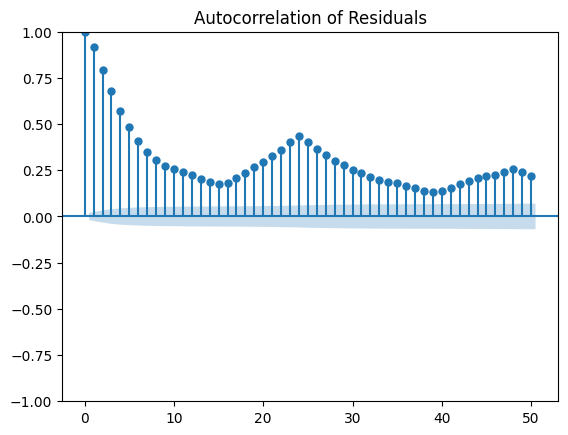

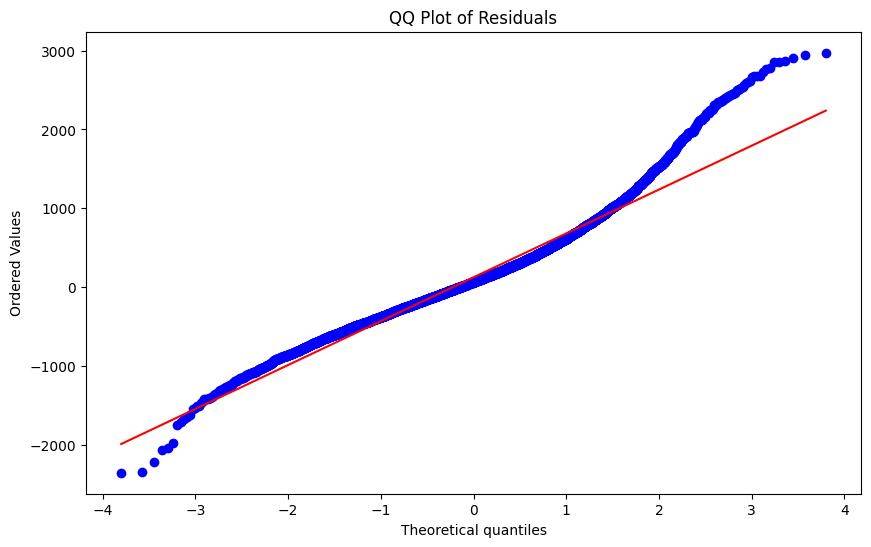

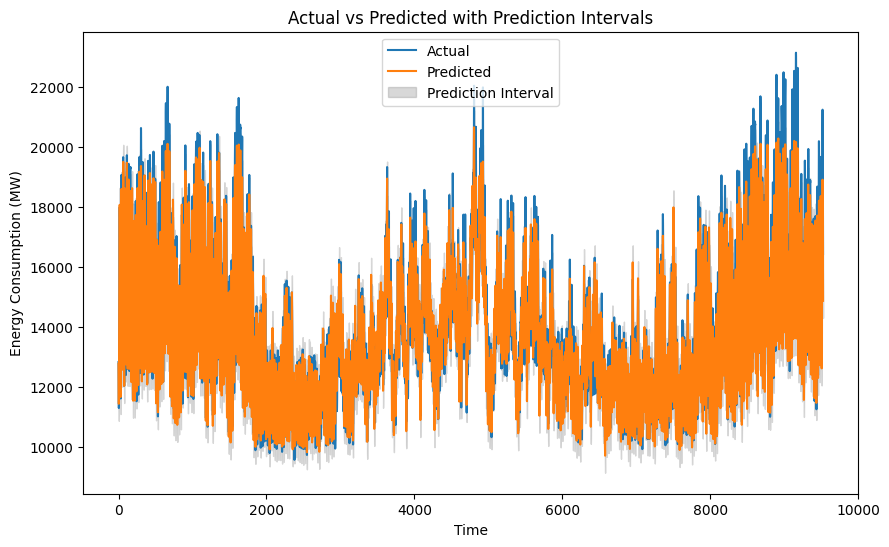

In [19]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from datetime import datetime
import tensorflow as tf
import random

# Step 0: Set seeds for reproducibility
def set_seeds(seed=22):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # For GPU reproducibility (if applicable) - TensorFlow 2.x way
    # No need for explicit session management in TF 2.x

set_seeds()

# Step 1: Prepare the case study data (2020-2023 training, 2024 testing)
split_date_train = datetime(2023, 7, 1)
train = case_study_data.loc[case_study_data['datetime'] < split_date_train].copy()
test = case_study_data.loc[case_study_data['datetime'] >= split_date_train].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Step 2: Normalize the data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input to be [samples, time steps, features] for LSTM
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Step 3: Load the best pre-trained model
loaded_model = load_model('lstm_energy_model1.h5')

# Step 3.1: Recompile the loaded model with a fresh optimizer
loaded_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Step 4: Retrain the loaded model on 2020-2023 data
history = loaded_model.fit(X_train_scaled, y_train_scaled,
                           validation_data=(X_test_scaled, y_test_scaled),
                           epochs=100,
                           batch_size=1000,
                           verbose=1)

# Step 5: Make predictions on 2024 data
predictions = loaded_model.predict(X_test_scaled)

# Step 6: Define the evaluation and plotting function
def evaluate_and_plot_model(y_true, y_pred, history=None):
    y_true_inv = scaler_y.inverse_transform(y_true)
    y_pred_inv = scaler_y.inverse_transform(y_pred)

    # Calculate evaluation metrics
    rmse = mean_squared_error(y_true_inv, y_pred_inv, squared=False)
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv)
    r2=r2_score(y_true_inv, y_pred_inv)

    # Print evaluation metrics
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"R2: {r2}")




    # 6.1 Loss Curve
    if history is not None:
        plt.figure(figsize=(10,6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Mean Squared Error)')
        plt.legend()
        plt.show()

    # 6.2 Residual Plot
    residuals = y_true_inv - y_pred_inv
    plt.figure(figsize=(10,6))
    plt.scatter(range(len(residuals)), residuals)
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Samples')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.show()

    # 6.3 Actual vs Predicted Scatter Plot
    plt.figure(figsize=(10,6))
    plt.scatter(y_true_inv, y_pred_inv, alpha=0.5)
    plt.plot([y_true_inv.min(), y_true_inv.max()], [y_true_inv.min(), y_true_inv.max()], 'r--')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    # 6.4 Error Distribution (Histogram)
    plt.figure(figsize=(10,6))
    plt.hist(residuals, bins=50, alpha=0.7)
    plt.title('Residual Error Distribution')
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.show()

    # 6.5 Prediction Error Over Time
    plt.figure(figsize=(10,6))
    plt.plot(residuals, label='Prediction Error')
    plt.title('Prediction Error Over Time')
    plt.xlabel('Time (Sample Index)')
    plt.ylabel('Prediction Error (Residuals)')
    plt.axhline(0, color='r', linestyle='--')
    plt.legend()
    plt.show()

    # 6.6 Cumulative Prediction Error
    cumulative_error = np.cumsum(residuals)
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_error, label='Cumulative Error')
    plt.title('Cumulative Prediction Error Over Time')
    plt.xlabel('Time (Sample Index)')
    plt.ylabel('Cumulative Error')
    plt.axhline(0, color='r', linestyle='--')
    plt.legend()
    plt.show()

    # 6.7 Actual vs Predicted Over Time
    plt.figure(figsize=(10,6))
    plt.plot(y_true_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.title('Actual vs Predicted Energy Consumption Over Time')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()

    # 7.1 Rolling Mean of Residuals
    rolling_window = 100  # Adjust this window size
    rolling_mean_residual = pd.Series(residuals.flatten()).rolling(window=rolling_window).mean()
    plt.figure(figsize=(10,6))
    plt.plot(rolling_mean_residual, label=f'Rolling Mean of Residuals ({rolling_window} samples)')
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Rolling Mean of Residuals')
    plt.xlabel('Samples')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.legend()
    plt.show()

    # 7.2 Autocorrelation of Residuals
    plt.figure(figsize=(10,6))
    sm.graphics.tsa.plot_acf(residuals.flatten(), lags=50)
    plt.title('Autocorrelation of Residuals')
    plt.show()

    # 7.3 QQ Plot of Residuals
    plt.figure(figsize=(10,6))
    stats.probplot(residuals.flatten(), dist="norm", plot=plt)
    plt.title('QQ Plot of Residuals')
    plt.show()

    # 7.4 Prediction Interval
    residual_std = np.std(residuals)
    upper_bound = y_pred_inv + residual_std
    lower_bound = y_pred_inv - residual_std
    plt.figure(figsize=(10,6))
    plt.plot(y_true_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.fill_between(range(len(y_true_inv)), lower_bound.flatten(), upper_bound.flatten(), color='gray', alpha=0.3, label='Prediction Interval')
    plt.title('Actual vs Predicted with Prediction Intervals')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()

# Step 7: Evaluate the retrained model and plot results
evaluate_and_plot_model(y_test_scaled, predictions, history)


In [20]:
# Save the model after training
loaded_model.save('lstm_case_study_energy_model1.h5')

In [21]:
loaded_model.save('lstm_case_study_energy_model1.keras')

# Test

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.0040 - val_loss: 0.0030
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0024 - val_loss: 0.0022
Epoch 3/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0022 - val_loss: 0.0020
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0020 - val_loss: 0.0018
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step

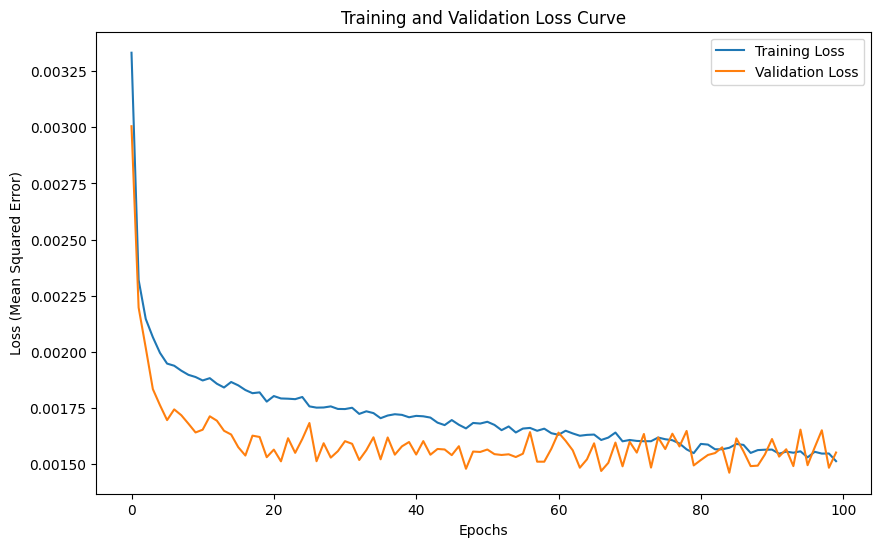

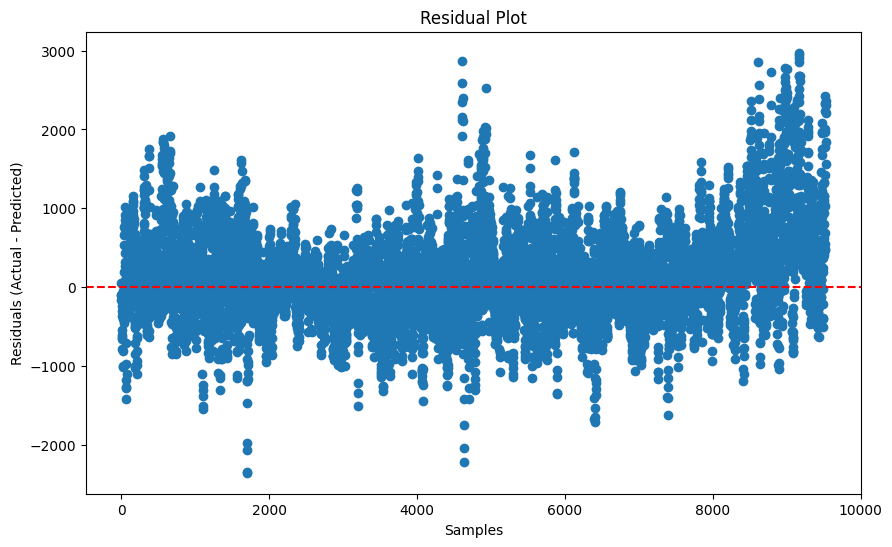

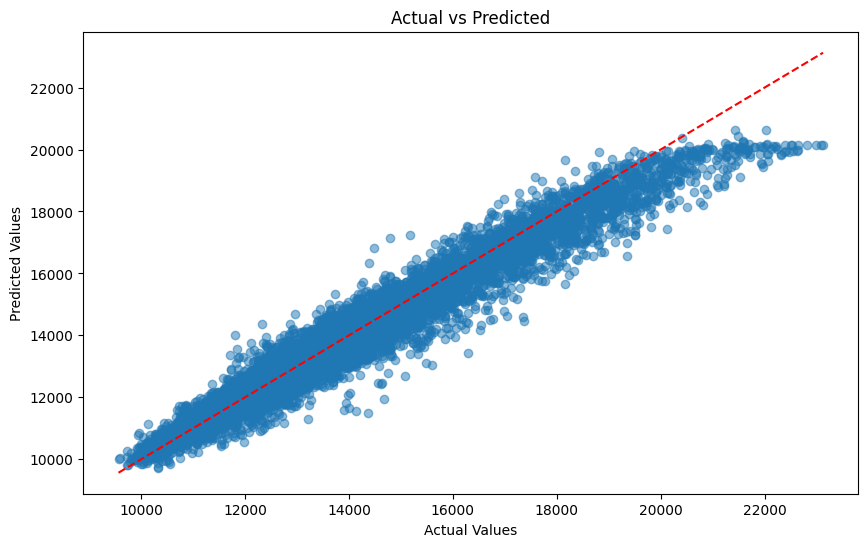

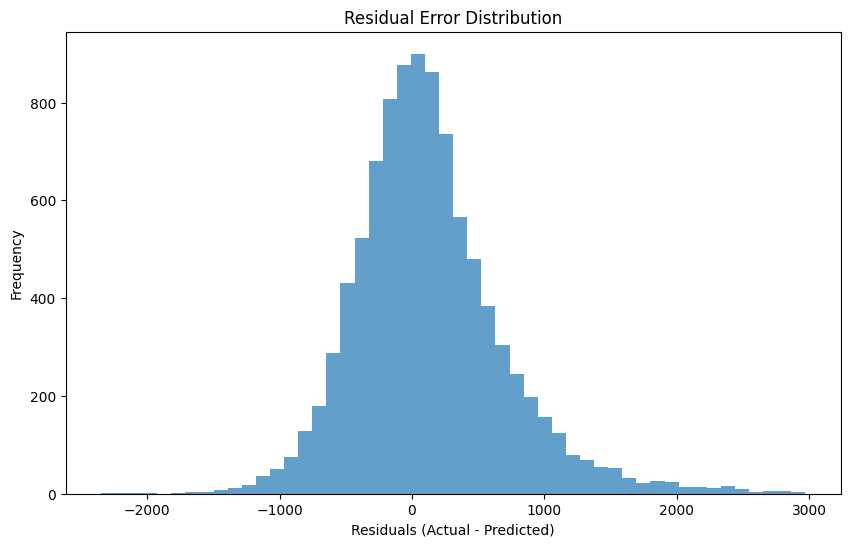

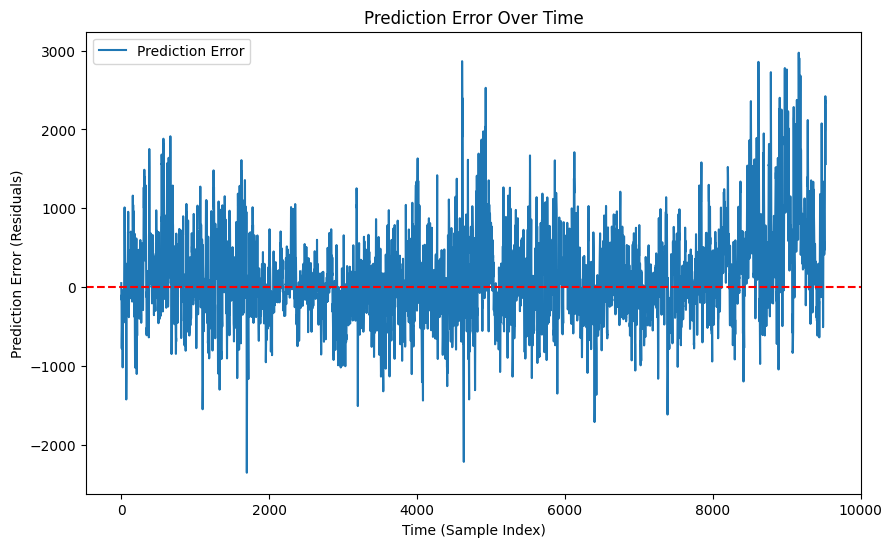

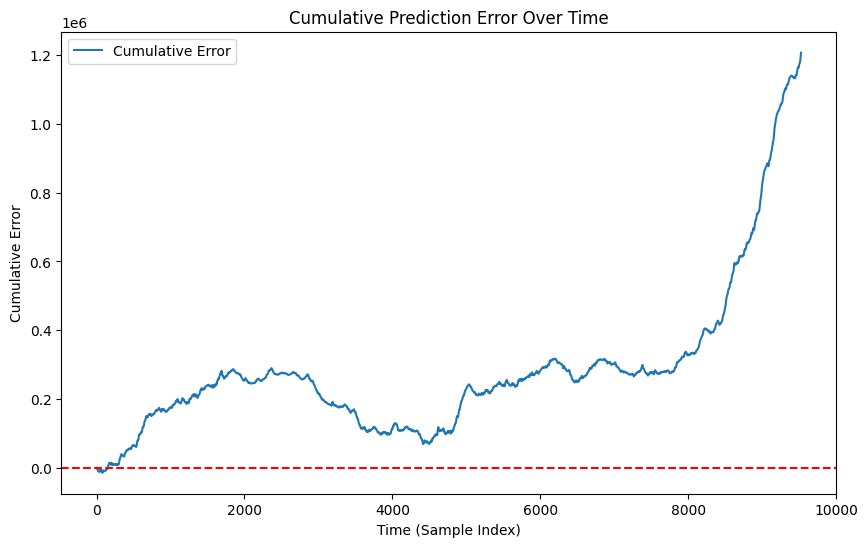

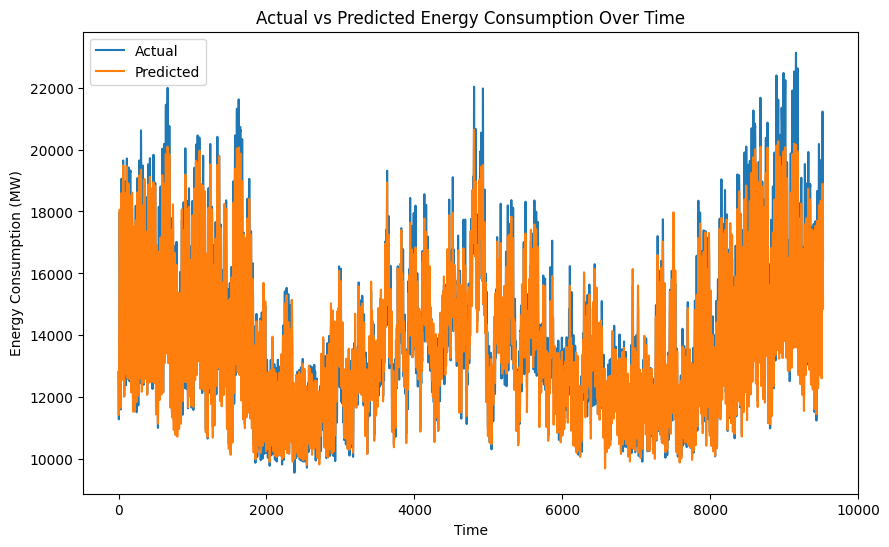

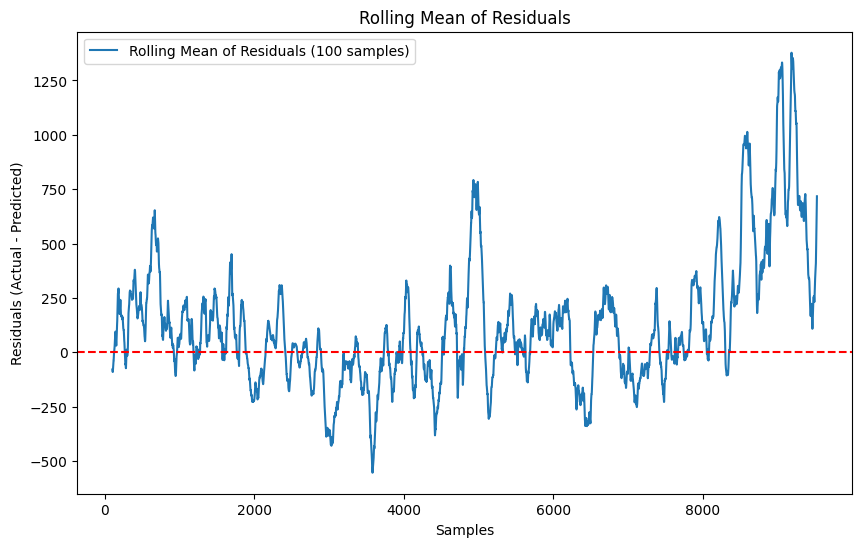

<Figure size 1000x600 with 0 Axes>

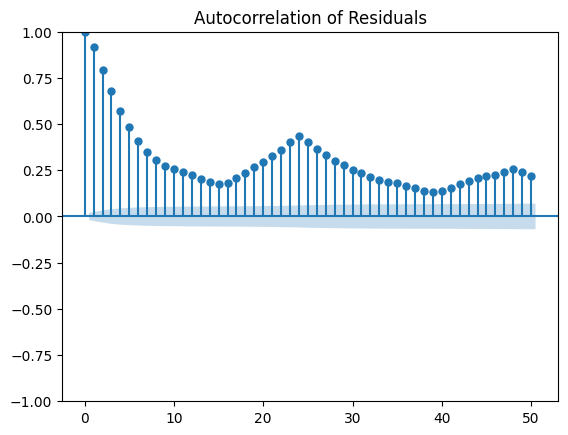

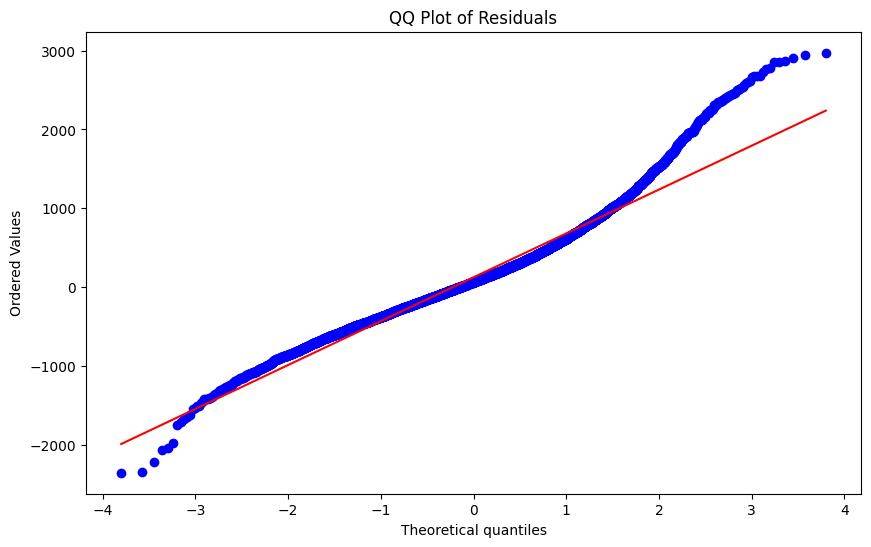

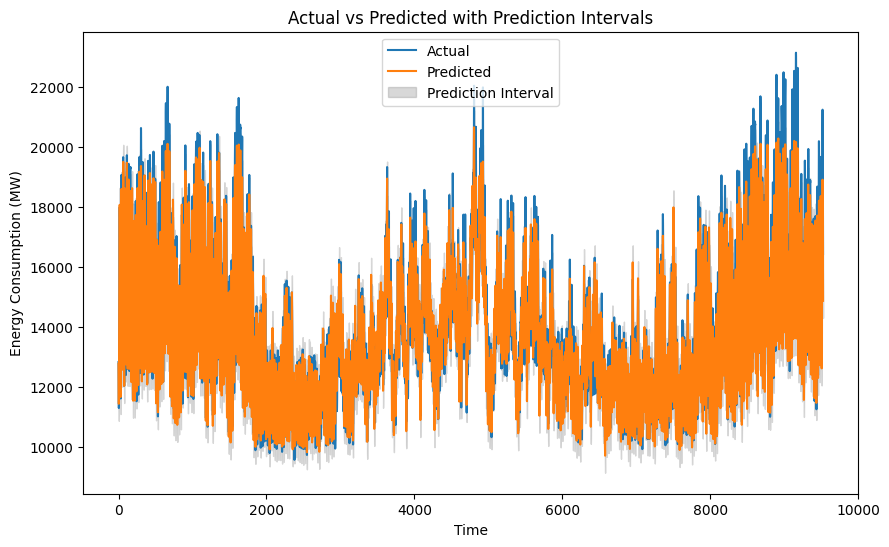

In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from datetime import datetime
import tensorflow as tf
import random

# Step 0: Set seeds for reproducibility
def set_seeds(seed=22):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    # For GPU reproducibility (if applicable) - TensorFlow 2.x way
    # No need for explicit session management in TF 2.x

set_seeds()

# Step 1: Prepare the case study data (2020-2023 training, 2024 testing)
split_date_train = datetime(2023, 7, 1)
train = case_study_data.loc[case_study_data['datetime'] < split_date_train].copy()
test = case_study_data.loc[case_study_data['datetime'] >= split_date_train].copy()

train_drop_cols = ['date', 'datetime', 'energy_consumption_mw']
X_train = train.drop(columns=train_drop_cols)
y_train = train['energy_consumption_mw']
X_test = test.drop(columns=train_drop_cols)
y_test = test['energy_consumption_mw']

# Step 2: Normalize the data using MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

# Reshape input to be [samples, time steps, features] for LSTM
X_train_scaled = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Step 3: Load the best pre-trained model
loaded_model = load_model('lstm_energy_model1.h5')

# Step 3.1: Recompile the loaded model with a fresh optimizer
loaded_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Step 4: Retrain the loaded model on 2020-2023 data
history = loaded_model.fit(X_train_scaled, y_train_scaled,
                           validation_data=(X_test_scaled, y_test_scaled),
                           epochs=100,
                           batch_size=1000,
                           verbose=1)

# Step 5: Make predictions on 2024 data
predictions = loaded_model.predict(X_test_scaled)

# Step 6: Define the evaluation and plotting function
def evaluate_and_plot_model(y_true, y_pred, history=None):
    y_true_inv = scaler_y.inverse_transform(y_true)
    y_pred_inv = scaler_y.inverse_transform(y_pred)

    # Calculate evaluation metrics
    rmse = mean_squared_error(y_true_inv, y_pred_inv, squared=False)
    mae = mean_absolute_error(y_true_inv, y_pred_inv)
    mape = mean_absolute_percentage_error(y_true_inv, y_pred_inv)
    r2=r2_score(y_true_inv, y_pred_inv)

    # Print evaluation metrics
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MAPE: {mape}")
    print(f"R2: {r2}")




    # 6.1 Loss Curve
    if history is not None:
        plt.figure(figsize=(10,6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Training and Validation Loss Curve')
        plt.xlabel('Epochs')
        plt.ylabel('Loss (Mean Squared Error)')
        plt.legend()
        plt.show()

    # 6.2 Residual Plot
    residuals = y_true_inv - y_pred_inv
    plt.figure(figsize=(10,6))
    plt.scatter(range(len(residuals)), residuals)
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Residual Plot')
    plt.xlabel('Samples')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.show()

    # 6.3 Actual vs Predicted Scatter Plot
    plt.figure(figsize=(10,6))
    plt.scatter(y_true_inv, y_pred_inv, alpha=0.5)
    plt.plot([y_true_inv.min(), y_true_inv.max()], [y_true_inv.min(), y_true_inv.max()], 'r--')
    plt.title('Actual vs Predicted')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.show()

    # 6.4 Error Distribution (Histogram)
    plt.figure(figsize=(10,6))
    plt.hist(residuals, bins=50, alpha=0.7)
    plt.title('Residual Error Distribution')
    plt.xlabel('Residuals (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.show()

    # 6.5 Prediction Error Over Time
    plt.figure(figsize=(10,6))
    plt.plot(residuals, label='Prediction Error')
    plt.title('Prediction Error Over Time')
    plt.xlabel('Time (Sample Index)')
    plt.ylabel('Prediction Error (Residuals)')
    plt.axhline(0, color='r', linestyle='--')
    plt.legend()
    plt.show()

    # 6.6 Cumulative Prediction Error
    cumulative_error = np.cumsum(residuals)
    plt.figure(figsize=(10,6))
    plt.plot(cumulative_error, label='Cumulative Error')
    plt.title('Cumulative Prediction Error Over Time')
    plt.xlabel('Time (Sample Index)')
    plt.ylabel('Cumulative Error')
    plt.axhline(0, color='r', linestyle='--')
    plt.legend()
    plt.show()

    # 6.7 Actual vs Predicted Over Time
    plt.figure(figsize=(10,6))
    plt.plot(y_true_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.title('Actual vs Predicted Energy Consumption Over Time')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()

    # 7.1 Rolling Mean of Residuals
    rolling_window = 100  # Adjust this window size
    rolling_mean_residual = pd.Series(residuals.flatten()).rolling(window=rolling_window).mean()
    plt.figure(figsize=(10,6))
    plt.plot(rolling_mean_residual, label=f'Rolling Mean of Residuals ({rolling_window} samples)')
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Rolling Mean of Residuals')
    plt.xlabel('Samples')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.legend()
    plt.show()

    # 7.2 Autocorrelation of Residuals
    plt.figure(figsize=(10,6))
    sm.graphics.tsa.plot_acf(residuals.flatten(), lags=50)
    plt.title('Autocorrelation of Residuals')
    plt.show()

    # 7.3 QQ Plot of Residuals
    plt.figure(figsize=(10,6))
    stats.probplot(residuals.flatten(), dist="norm", plot=plt)
    plt.title('QQ Plot of Residuals')
    plt.show()

    # 7.4 Prediction Interval
    residual_std = np.std(residuals)
    upper_bound = y_pred_inv + residual_std
    lower_bound = y_pred_inv - residual_std
    plt.figure(figsize=(10,6))
    plt.plot(y_true_inv, label='Actual')
    plt.plot(y_pred_inv, label='Predicted')
    plt.fill_between(range(len(y_true_inv)), lower_bound.flatten(), upper_bound.flatten(), color='gray', alpha=0.3, label='Prediction Interval')
    plt.title('Actual vs Predicted with Prediction Intervals')
    plt.xlabel('Time')
    plt.ylabel('Energy Consumption (MW)')
    plt.legend()
    plt.show()

# Step 7: Evaluate the retrained model and plot results
evaluate_and_plot_model(y_test_scaled, predictions, history)
